In [1]:
# Data manipulation and processing
import pandas as pd
import numpy as np

# Geospatial data processing
import geopandas as gpd
from shapely.geometry import LineString, Point

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FixedLocator
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# System operations
import os

In [2]:
root = r'C:\Users\DELL\Desktop'

In [3]:
od1903 = pd.read_csv(os.path.join(root, 'data', 'od201903.csv'))
od2403 = pd.read_csv(os.path.join(root, 'data', 'od202403.csv'))

In [4]:
city_grid = gpd.read_file(os.path.join(root, 'data', 'shp', 'ss_city_grid.shp'))
sixth = gpd.read_file(os.path.join(root, 'data', 'shp', 'SixthRing_Polygon.shp'))
sixth_fnid = city_grid.sjoin(sixth, how='inner', predicate='intersects')['fnid'].unique()

In [5]:
def shannon_entropy(row):
    proportions = row / row.sum()
    entropy = -np.sum(proportions * np.log(proportions + 1e-10))
    return entropy

In [6]:
visit_iso1903 = pd.read_csv(os.path.join(root, 'data', 'visit_iso1903.csv'))
visit_iso2403 = pd.read_csv(os.path.join(root, 'data', 'visit_iso2403.csv'))

visit_poi_num2019 = pd.read_csv(os.path.join(root, 'data', 'visit_poi_num2019.csv')).rename(columns={'fnid':'visit_grid'})
visit_poi_num2019['poi_num'] = visit_poi_num2019.iloc[:,1:].sum(axis=1)
visit_poi_num2019['poi_entropy'] = visit_poi_num2019.iloc[:,1:-1].apply(shannon_entropy, axis=1)
visit_poi_num2024 = pd.read_csv(os.path.join(root, 'data', 'visit_poi_num2024.csv')).rename(columns={'fnid':'visit_grid'})
visit_poi_num2024['poi_num'] = visit_poi_num2024.iloc[:,1:].sum(axis=1)
visit_poi_num2024['poi_entropy'] = visit_poi_num2024.iloc[:,1:-1].apply(shannon_entropy, axis=1)

visit_ses_geo1903_six = pd.read_csv(os.path.join(root, 'data', 'visit_ses_geo1903_six.csv'))
visit_ses_geo2403_six = pd.read_csv(os.path.join(root, 'data', 'visit_ses_geo2403_six.csv'))

In [7]:
visit_attr1903 = visit_iso1903.merge(visit_ses_geo1903_six).merge(visit_poi_num2019.loc[:,['visit_grid','poi_num','poi_entropy']])
visit_attr2403 = visit_iso2403.merge(visit_ses_geo2403_six).merge(visit_poi_num2024.loc[:,['visit_grid','poi_num','poi_entropy']])

In [8]:
od_line_geo = pd.read_csv(os.path.join(root, 'data', 'od19_24_fnid_distance.csv'))

In [9]:
house_price_pop = pd.read_csv(os.path.join(root, 'data', 'house_price_pop.csv'))
pcount1903_attr = pd.read_csv(os.path.join(root, 'data', 'pcount1903_attr.csv'))
pcount2403_attr = pd.read_csv(os.path.join(root, 'data', 'pcount2403_attr.csv'))
home_poi_num2019 = pd.read_csv(os.path.join(root, 'data', 'home_poi_num2019.csv')).rename(columns={'fnid':'home_grid'})
home_poi_num2024 = pd.read_csv(os.path.join(root, 'data', 'home_poi_num2024.csv')).rename(columns={'fnid':'home_grid'})
home_poi_num2019['poi_num_home'] = home_poi_num2019.iloc[:,1:-1].sum(axis=1)
home_poi_num2024['poi_num_home'] = home_poi_num2024.iloc[:,1:-1].sum(axis=1)

In [10]:
visit_fre1903 = pd.read_csv(os.path.join(root, 'data', 'visit_fre1903.csv'))
visit_fre2403 = pd.read_csv(os.path.join(root, 'data', 'visit_fre2403.csv'))
visit_time1903 = pd.read_csv(os.path.join(root, 'data', 'visit_time1903.csv'))
visit_time2403 = pd.read_csv(os.path.join(root, 'data', 'visit_time2403.csv'))
visit_dis1903 = pd.read_csv(os.path.join(root, 'data', 'visit_dis1903.csv'))
visit_dis2403 = pd.read_csv(os.path.join(root, 'data', 'visit_dis2403.csv'))
visit_ent1903 = pd.read_csv(os.path.join(root, 'data', 'visit_ent1903.csv'))
visit_ent2403 = pd.read_csv(os.path.join(root, 'data', 'visit_ent2403.csv'))

In [11]:
ses = 'ses'
time = 'sum_time'
group_list = ['home_grid','age','gender','is_local']

visit_i1903 = visit_fre1903.merge(visit_time1903, on=group_list+['ses']).merge(visit_dis1903, on=group_list+['ses']).merge(visit_ent1903, on=group_list+['ses']).loc[:,group_list+['pcount','avg_fre','avg_time','avg_dis','entropy']]
visit_i2403 = visit_fre1903.merge(visit_time2403, on=group_list+['ses']).merge(visit_dis2403, on=group_list+['ses']).merge(visit_ent2403, on=group_list+['ses']).loc[:,group_list+['pcount','avg_fre','avg_time','avg_dis','entropy']]

def data_prepross(df):
    df = df.loc[df['visit_grid'].isin(sixth_fnid)]
    visit_count = df.loc[:,['visit_grid','home_grid']].groupby('visit_grid', as_index=False).count()
    df = df.loc[df['visit_grid'].isin(np.array(visit_count.loc[visit_count['home_grid']>=3]['visit_grid']))]
    visit_fre = df.loc[:,['home_grid','stay_fre']].groupby('home_grid', as_index=False).sum()
    df = df.loc[df['home_grid'].isin(visit_fre.loc[visit_fre['stay_fre']>10]['home_grid'])]
    df = df.loc[df['age'].isin(['a1','a2','a3','a4','a5','a6','a7'])]
    df.loc[(df['home_grid']==df['visit_grid']) & (df['ptype']!=1), 'ptype'] = 1
    df_ses = df.merge(house_price_pop.loc[:,['home_grid','ses','ses2', 'ses3']])
    return df_ses

def visit_prob_stat(od_data, visit_attr, home_poi, visit_i):
    data_new = data_prepross(od_data)
    data_new = data_new.merge(od_line_geo.loc[:,['home_grid', 'visit_grid', 'distance']], on=['home_grid', 'visit_grid'])
    data_visit = data_new.loc[(data_new['ptype']==0) & (data_new['distance']>356)]
    home_dis_df = data_visit.loc[data_visit[time]>0, group_list+[ses, 'visit_grid', time, 'distance']]
    home_dis_df['visit_prob'] = home_dis_df.loc[:,group_list+[time]].groupby(group_list)[time].transform(lambda x: x/x.sum())
    return home_dis_df.merge(visit_attr).merge(home_poi.loc[:,['home_grid','poi_num_home']]).merge(visit_i, on=group_list)

# visit_prob_stat1903 = visit_prob_stat(od1903, visit_attr1903, home_poi_num2019, visit_i1903)
# visit_prob_stat2403 = visit_prob_stat(od2403, visit_attr2403, home_poi_num2024, visit_i2403)

In [12]:
# visit_prob_stat1903.to_csv(os.path.join(root, 'data', 'visit_prob_stat1903.csv'), index=False)
# visit_prob_stat2403.to_csv(os.path.join(root, 'data', 'visit_prob_stat2403.csv'), index=False)

In [13]:
visit_prob_stat1903 = pd.read_csv(os.path.join(root, 'data', 'visit_prob_stat1903.csv'))
visit_prob_stat2403 = pd.read_csv(os.path.join(root, 'data', 'visit_prob_stat2403.csv'))

In [14]:
age_mapping = {
    'a1': 'young',
    'a2': 'young',
    'a3': 'young',
    'a4': 'middle',
    'a5': 'middle',
    'a6': 'old',
    'a7': 'old'}
gender_mapping = {
    1:'male',
    2:'female'
}
bins = [0, 25, 50, 75, 100]
labels = ['low', 'lower middle', 'upper middle', 'high']

visit_prob_stat1903['age_c'] = visit_prob_stat1903['age'].map(age_mapping)
visit_prob_stat1903['gender_c'] = visit_prob_stat1903['gender'].map(gender_mapping)
visit_prob_stat1903['ses_c'] = pd.cut(
    visit_prob_stat1903['ses'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

visit_prob_stat2403['age_c'] = visit_prob_stat2403['age'].map(age_mapping)
visit_prob_stat2403['gender_c'] = visit_prob_stat2403['gender'].map(gender_mapping)
visit_prob_stat2403['ses_c'] = pd.cut(
    visit_prob_stat2403['ses'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# Hypothetical scenario simulation

In [15]:
GROUP_COLS = ['home_grid', 'age', 'gender', 'is_local', 'ses']
SES_BINS = [0, 20, 40, 60, 80, 100]

def load_base_data(year):
    df = pd.read_csv(f'mobility_{year}.csv')
    df = df[df['age'].isin(['a2','a3','a4','a5','a6','a7'])]
    return df.merge(house_price_pop, on='home_grid')

In [16]:
class ScenarioProcessor:
    def __init__(self, base_df):
        self.df = base_df.copy()
    
    def apply_scenario(self, scenario_type, **params):
        if scenario_type == "top_locations":
            return self._top_k_locations(params.get('k', 10))
        elif scenario_type == "distance_range":
            return self._filter_distance(params['min'], params['max'])
        elif scenario_type == "poi_density":
            return self._filter_poi_density(params['threshold'])
        else:
            raise ValueError("Unknown scenario type")

    def _top_k_locations(self, k):
        return (self.df.sort_values('visit_prob', ascending=False)
                      .groupby(GROUP_COLS).head(k))

    def _filter_distance(self, d_min, d_max):
        return self.df[self.df['distance'].between(d_min, d_max)]

    def _filter_poi_density(self, threshold):
        return self.df[self.df['poi_num'] >= threshold]

In [17]:
def generate_analysis_results(filtered_df):
    matrix = (filtered_df.groupby(['ses', 'visit_grid'])['sum_time'].sum()
              .unstack().fillna(0))
    matrix = matrix.div(matrix.sum(axis=1), axis=0)
    se_index = calculate_se_index(matrix.values)
    
    return {
        'contact_matrix': matrix,
        'se_index': se_index,
        'entropy': calculate_entropy(matrix)
    }

def calculate_se_index(matrix, bandwidth=10):
    n = matrix.shape[0]
    mask = np.abs(np.arange(n) - np.arange(n)[:, None]) <= bandwidth
    return (matrix * mask).sum() / n

In [18]:
def run_all_scenarios(years=[2019, 2024]):
    scenarios = {
        'top_10': {'type': 'top_locations', 'k': 10},
        'mid_dist': {'type': 'distance_range', 'min': 5000, 'max': 20000},
        'high_poi': {'type': 'poi_density', 'threshold': 500}
    }

    results = {}
    for year in years:
        df = load_base_data(year)
        processor = ScenarioProcessor(df)
        
        year_results = {}
        for name, config in scenarios.items():
            filtered = processor.apply_scenario(**config)
            year_results[name] = generate_analysis_results(filtered)
        
        results[year] = year_results
    
    return results

In [19]:
def plot_scenario_comparison(results):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for i, (year, year_data) in enumerate(results.items()):
        for j, (scenario, data) in enumerate(year_data.items()):
            ax = axes[i,j]
            sns.heatmap(data['contact_matrix'], ax=ax, cmap='RdYlBu_r')
            ax.set_title(f"{year} {scenario}\nSE={data['se_index']:.2f}")
    plt.tight_layout()

# Results of running the scenario simulation

C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()


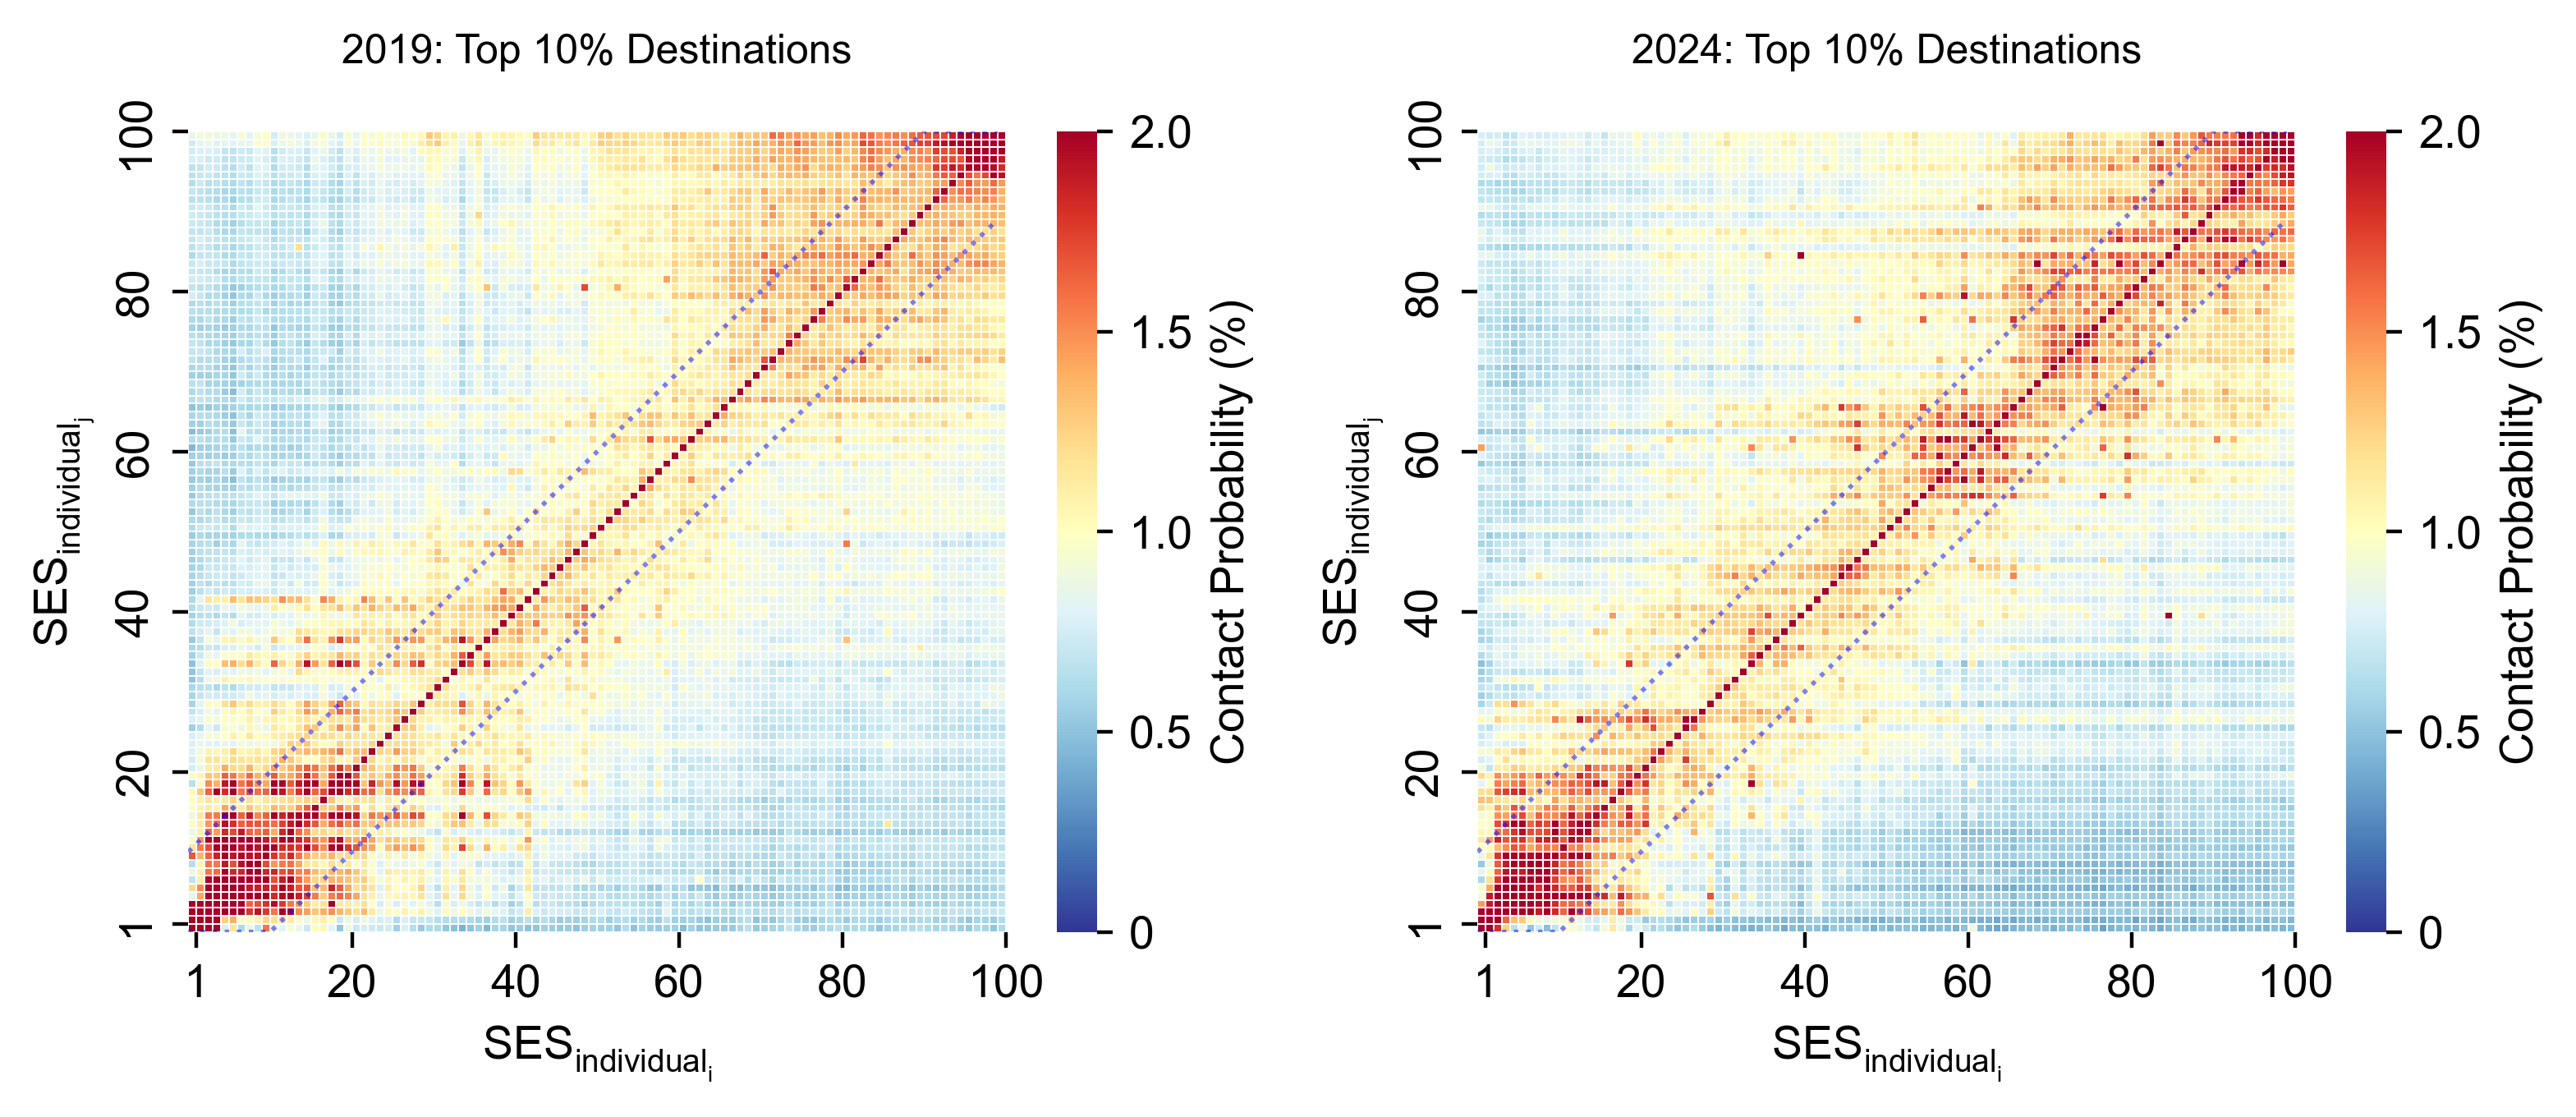

SE Index for Situation 1:
2019: 0.2985130052375101
2024: 0.3037525866037608


C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()


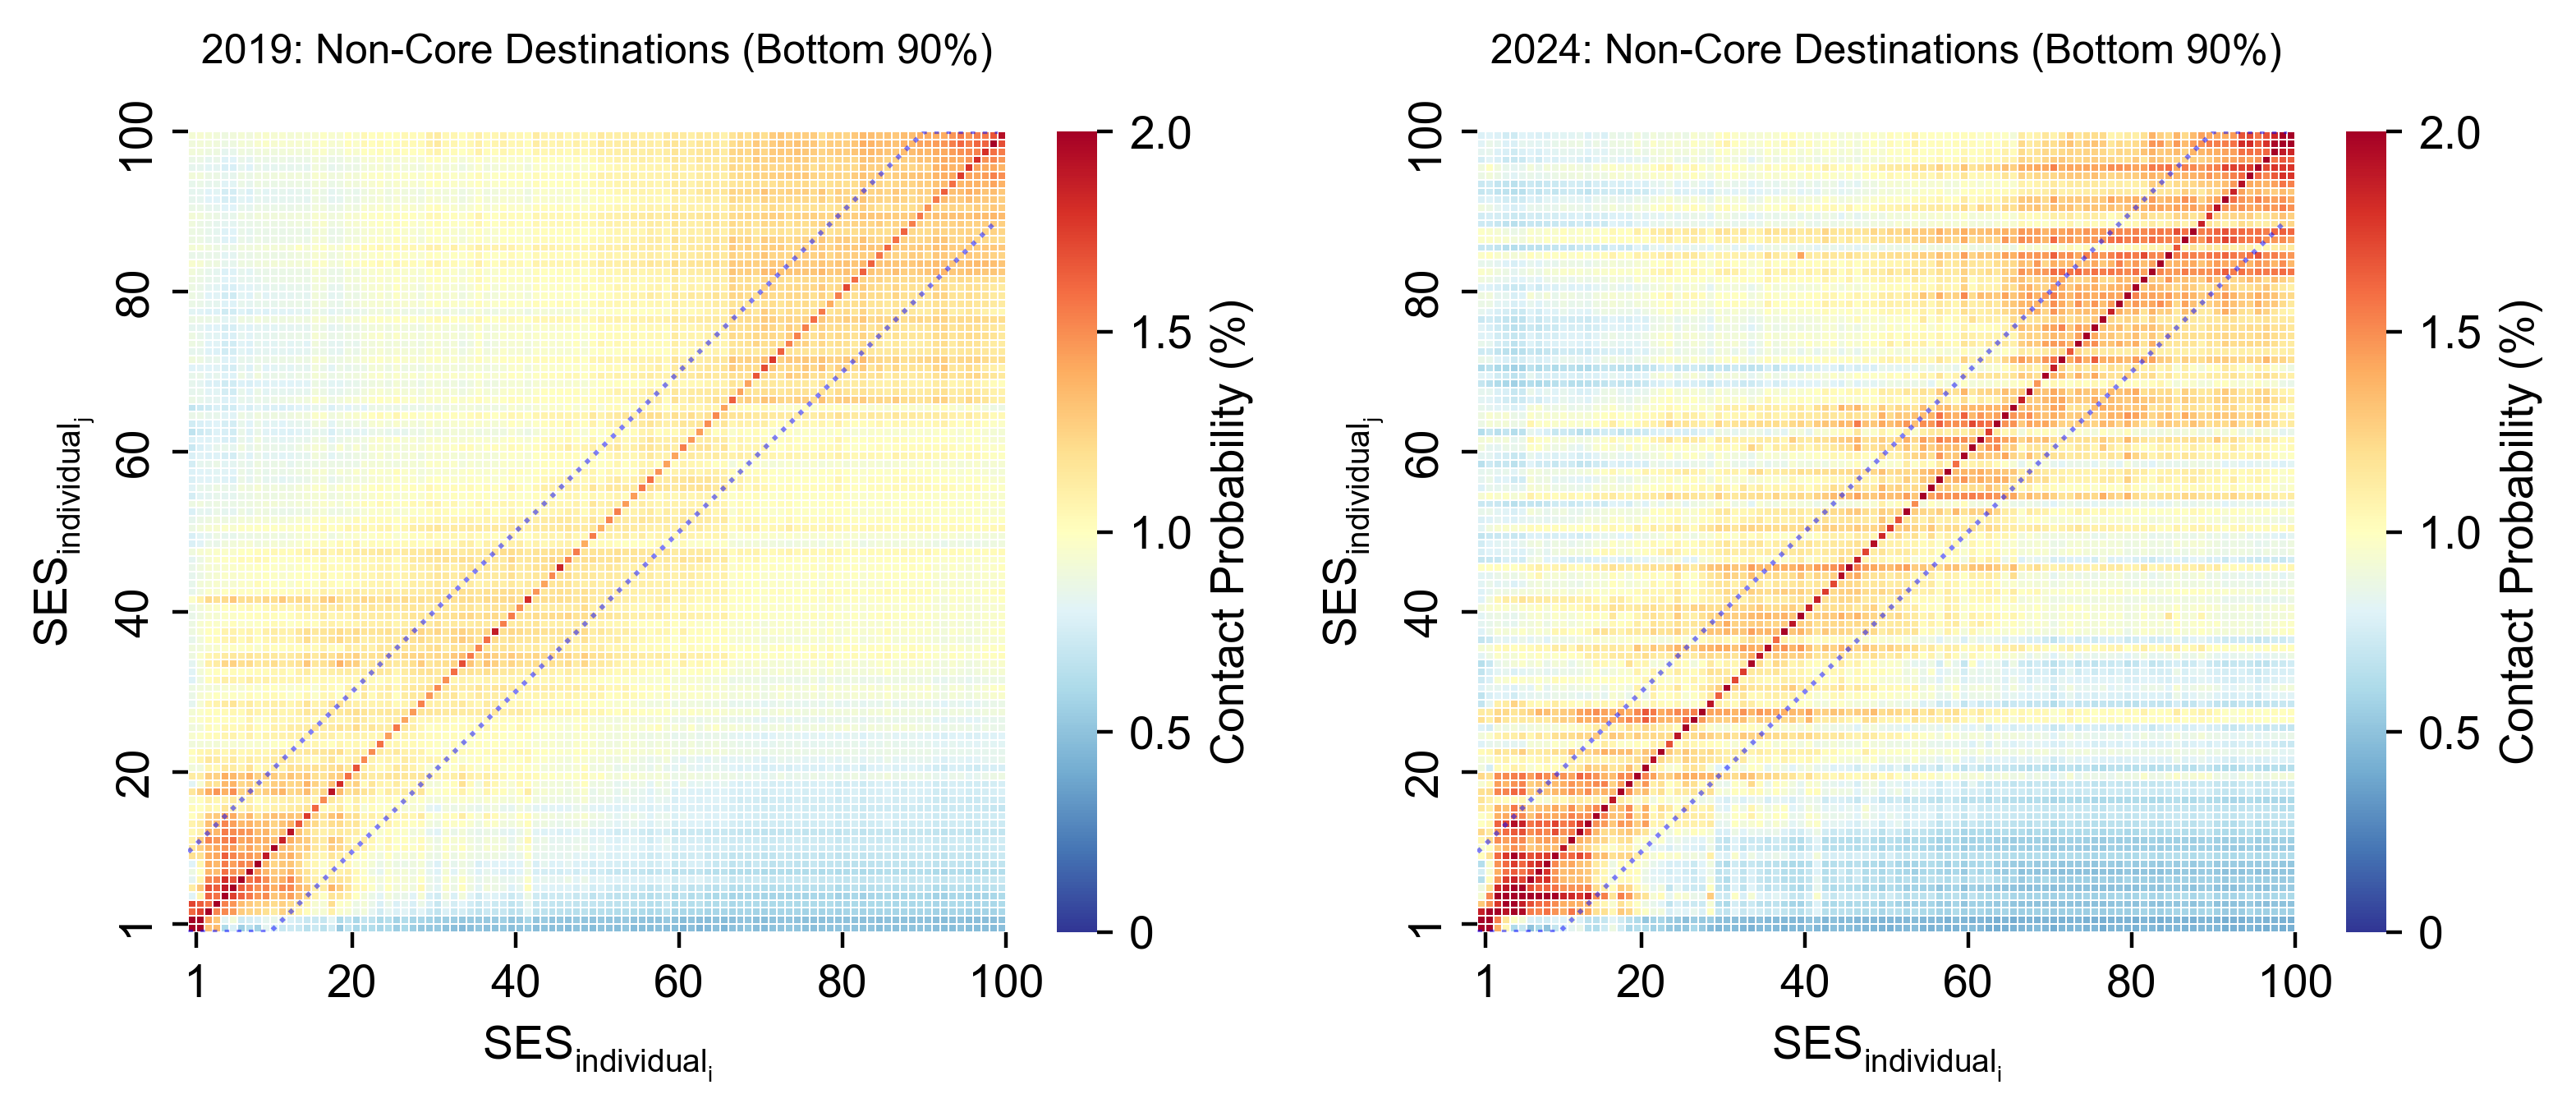

SE Index for Situation 2:
2019: 0.24146956523253688
2024: 0.2642672741167469


C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()


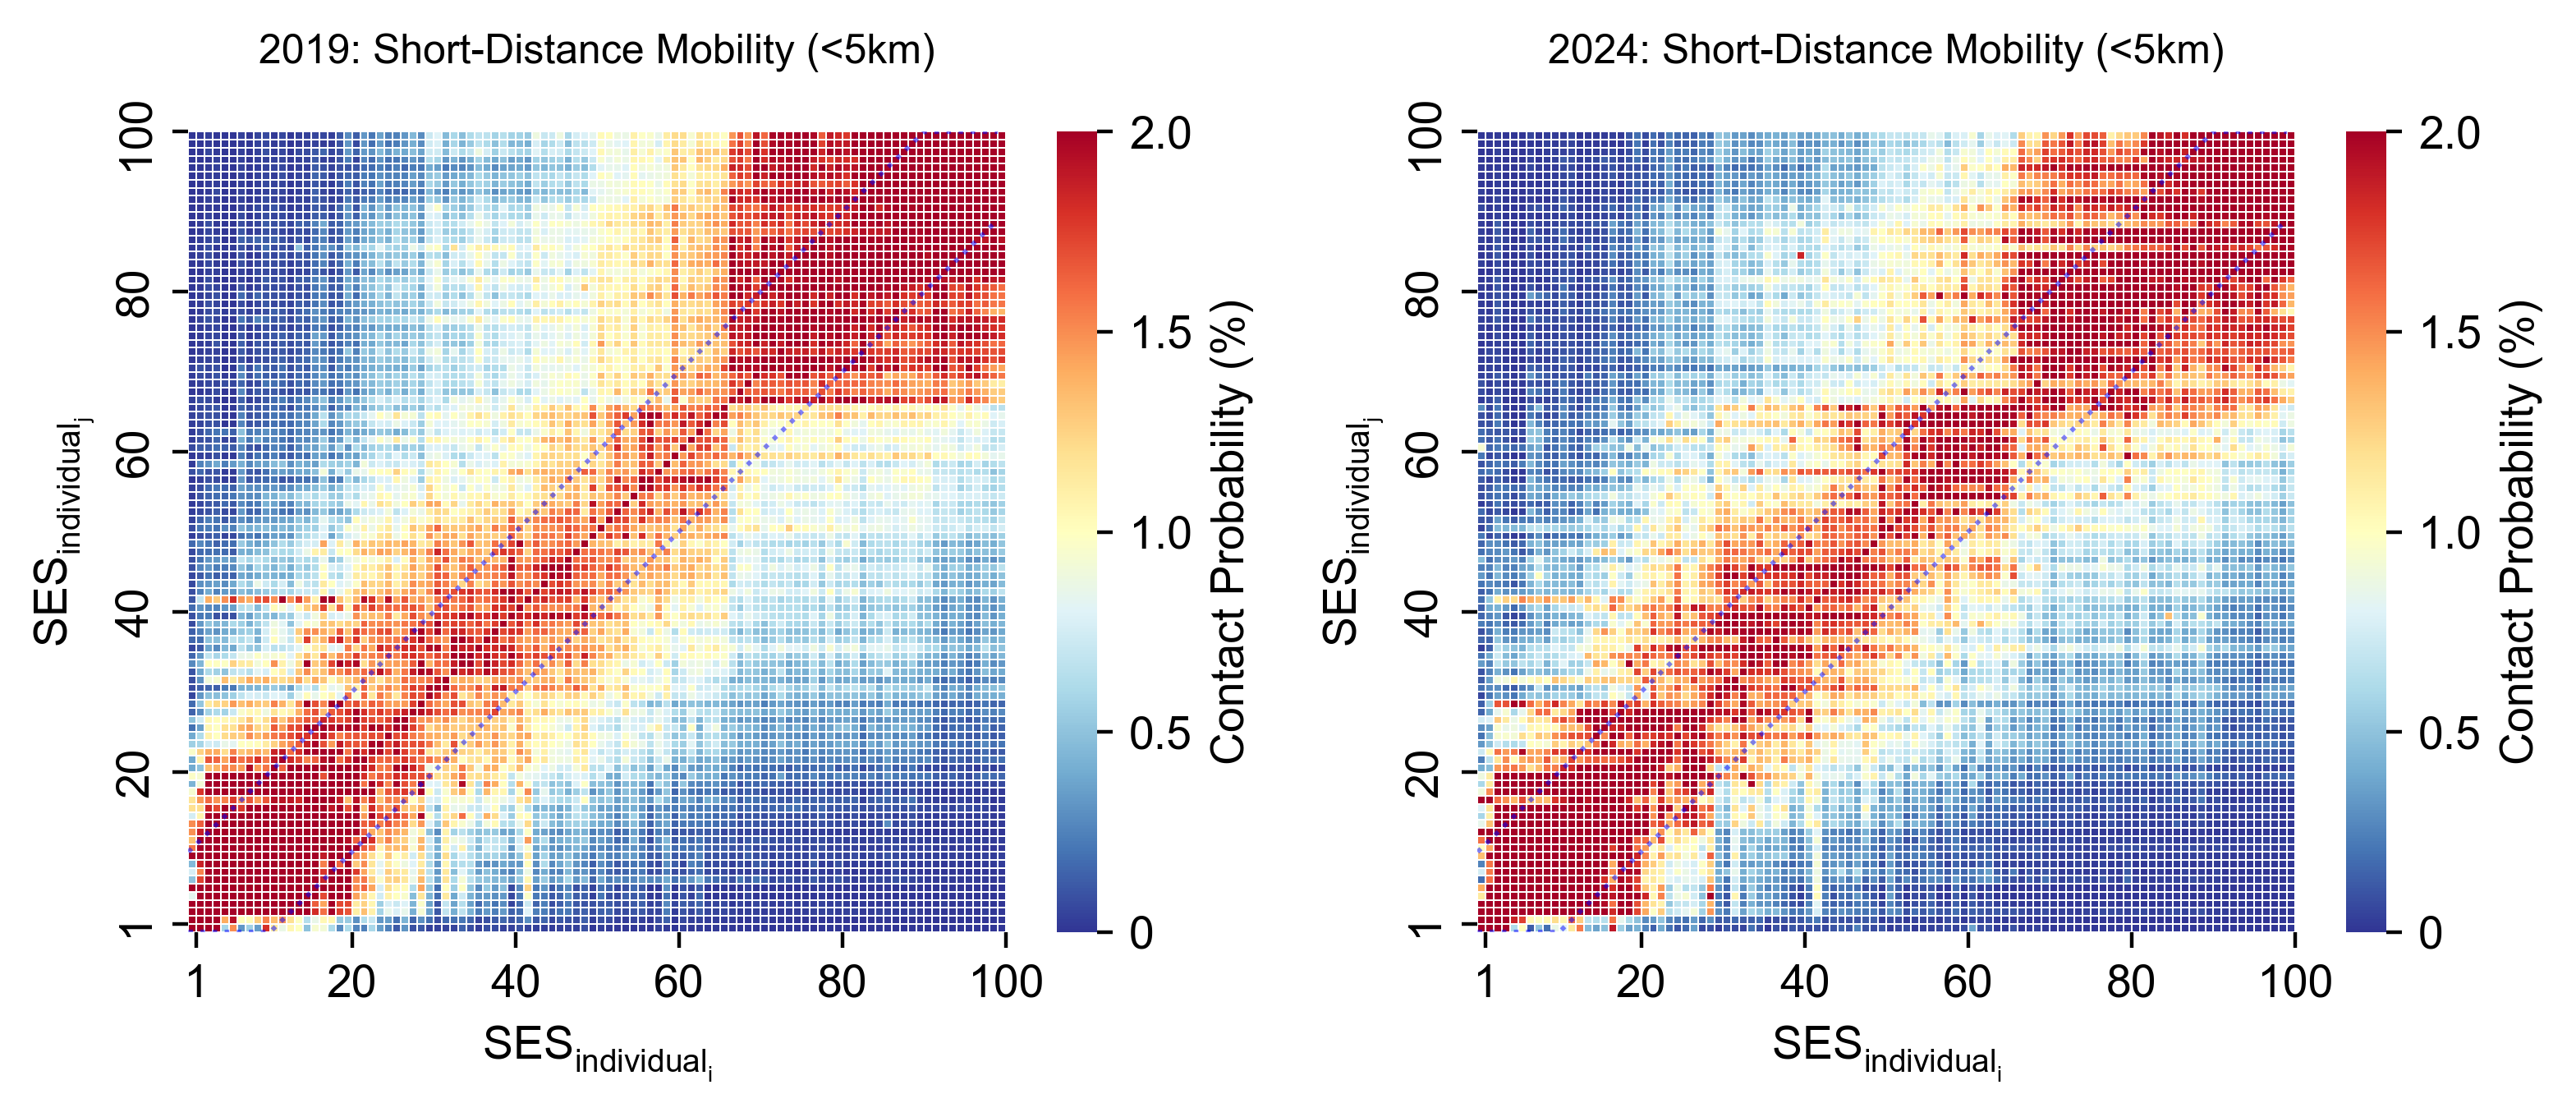

SE Index for Situation 3:
2019: 0.42638668758031045
2024: 0.4537444715532788


C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()


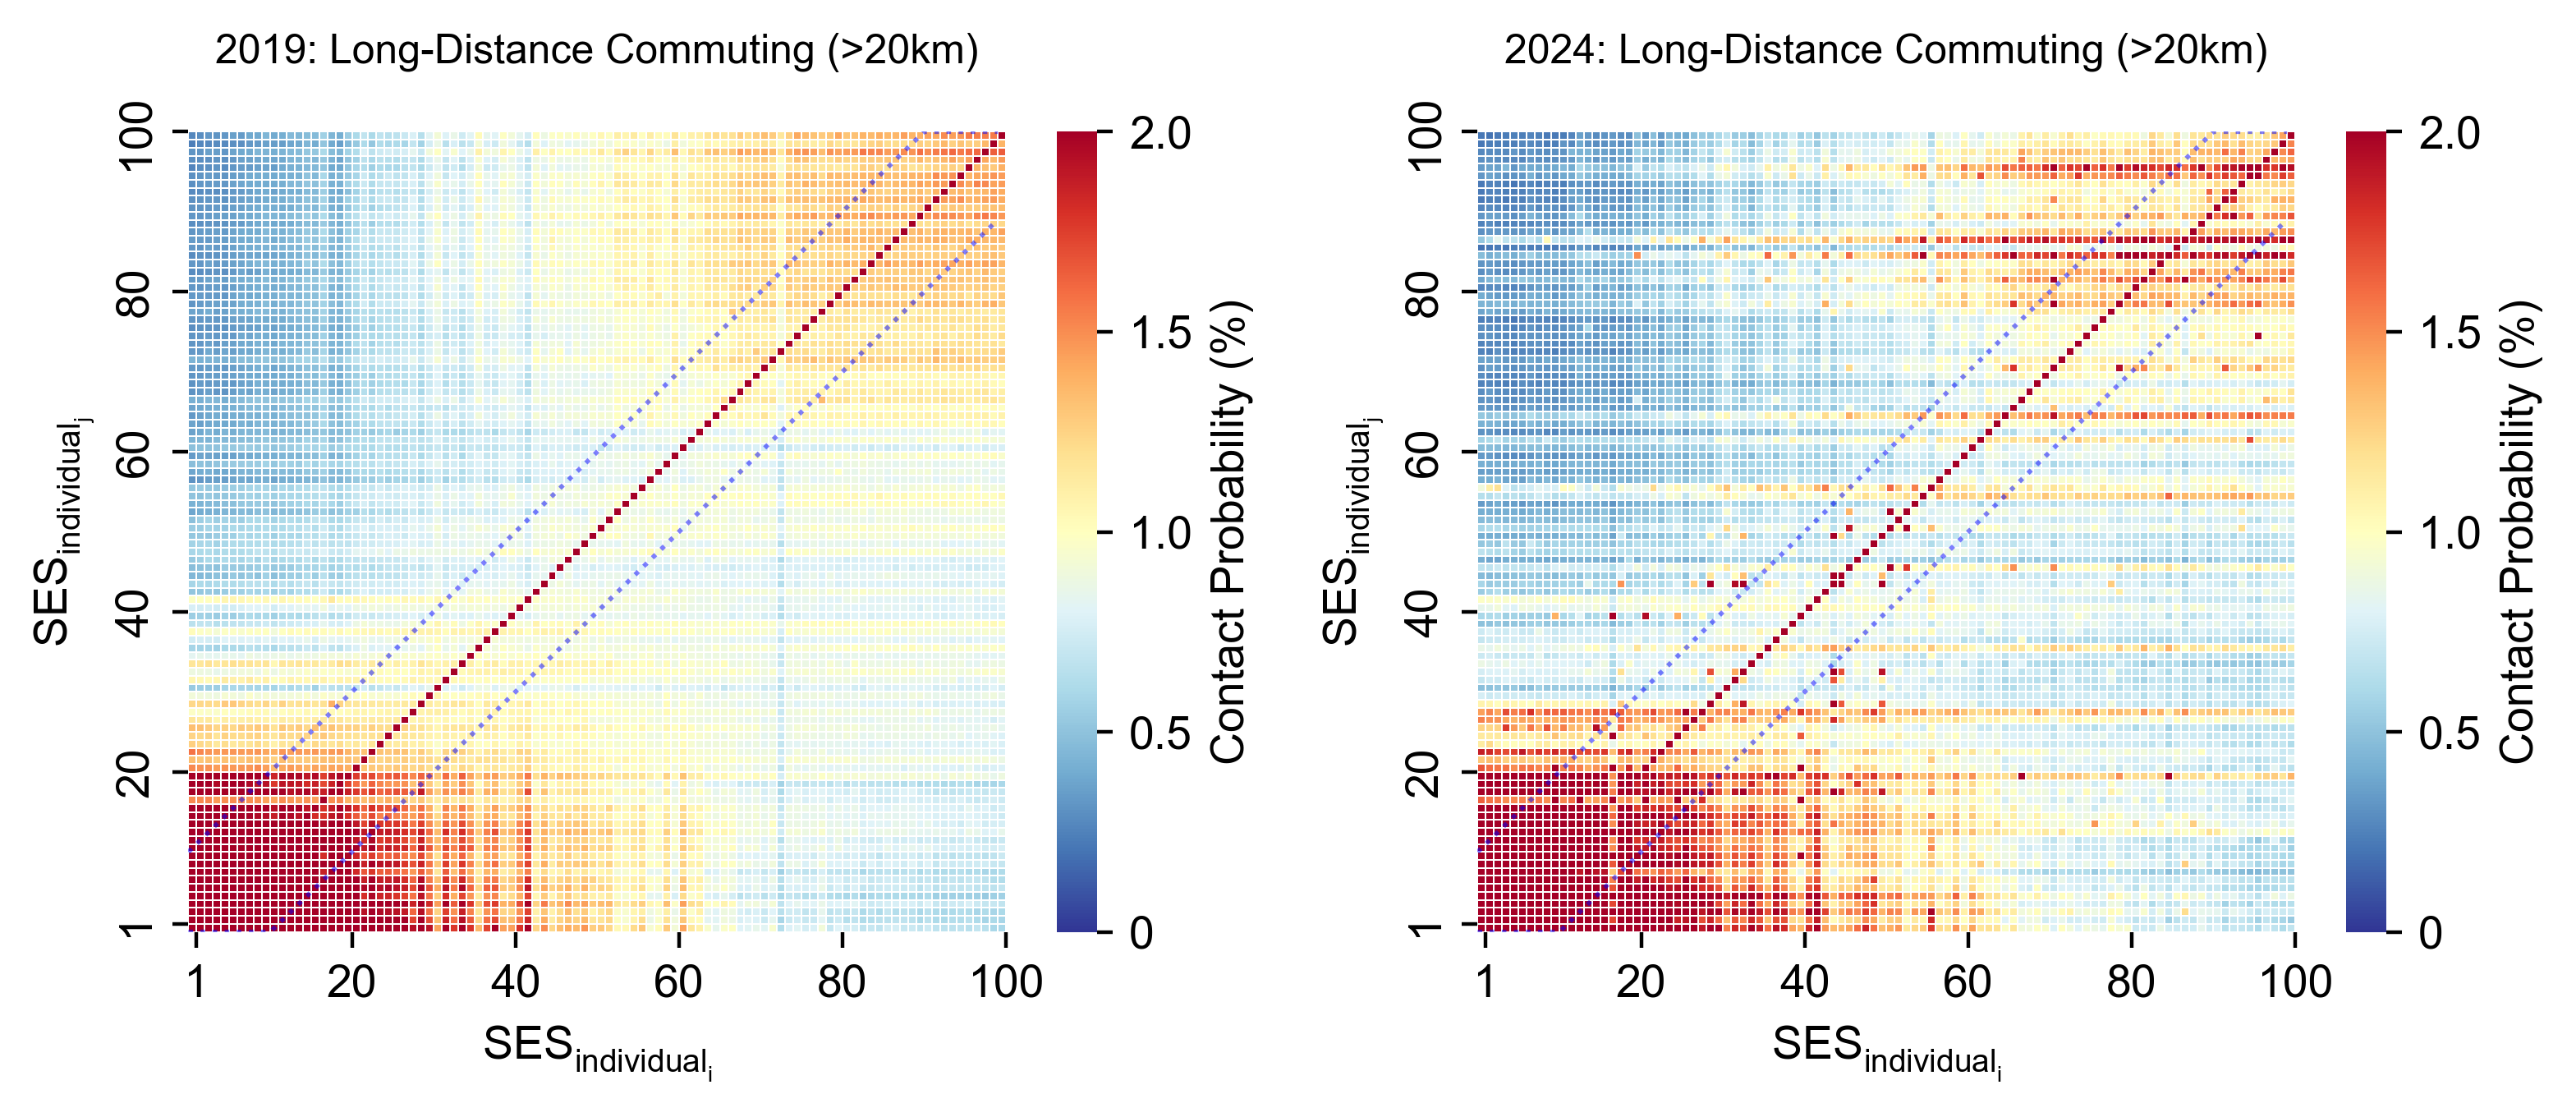

SE Index for Situation 4:
2019: 0.2806595177717595
2024: 0.3018264806941561


C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()


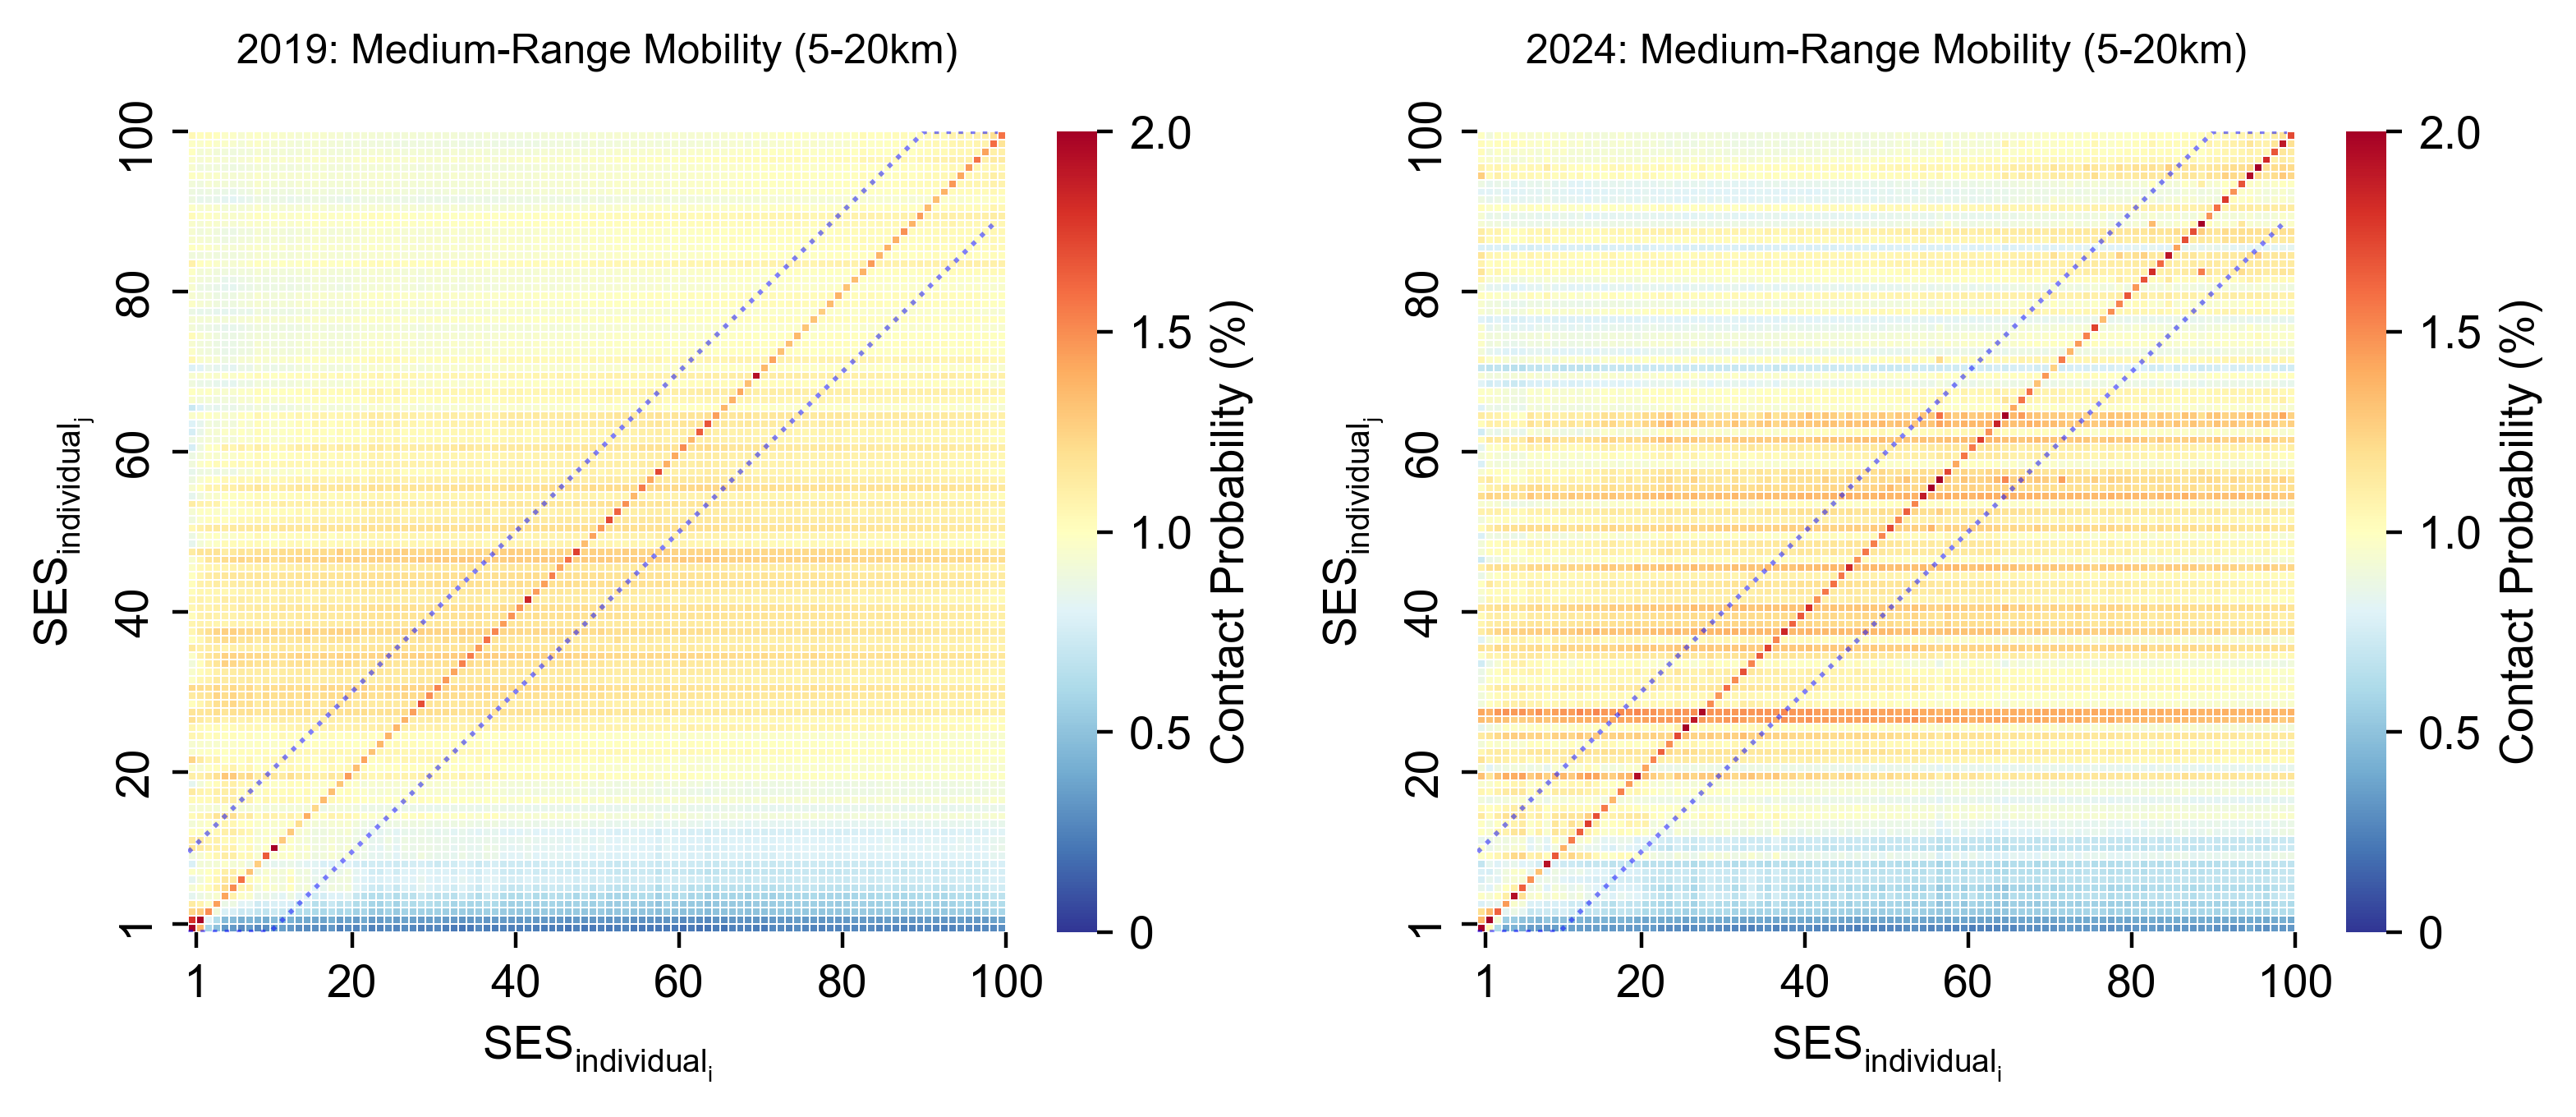

SE Index for Situation 5:
2019: 0.21601839406449636
2024: 0.21937877841652434


C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()


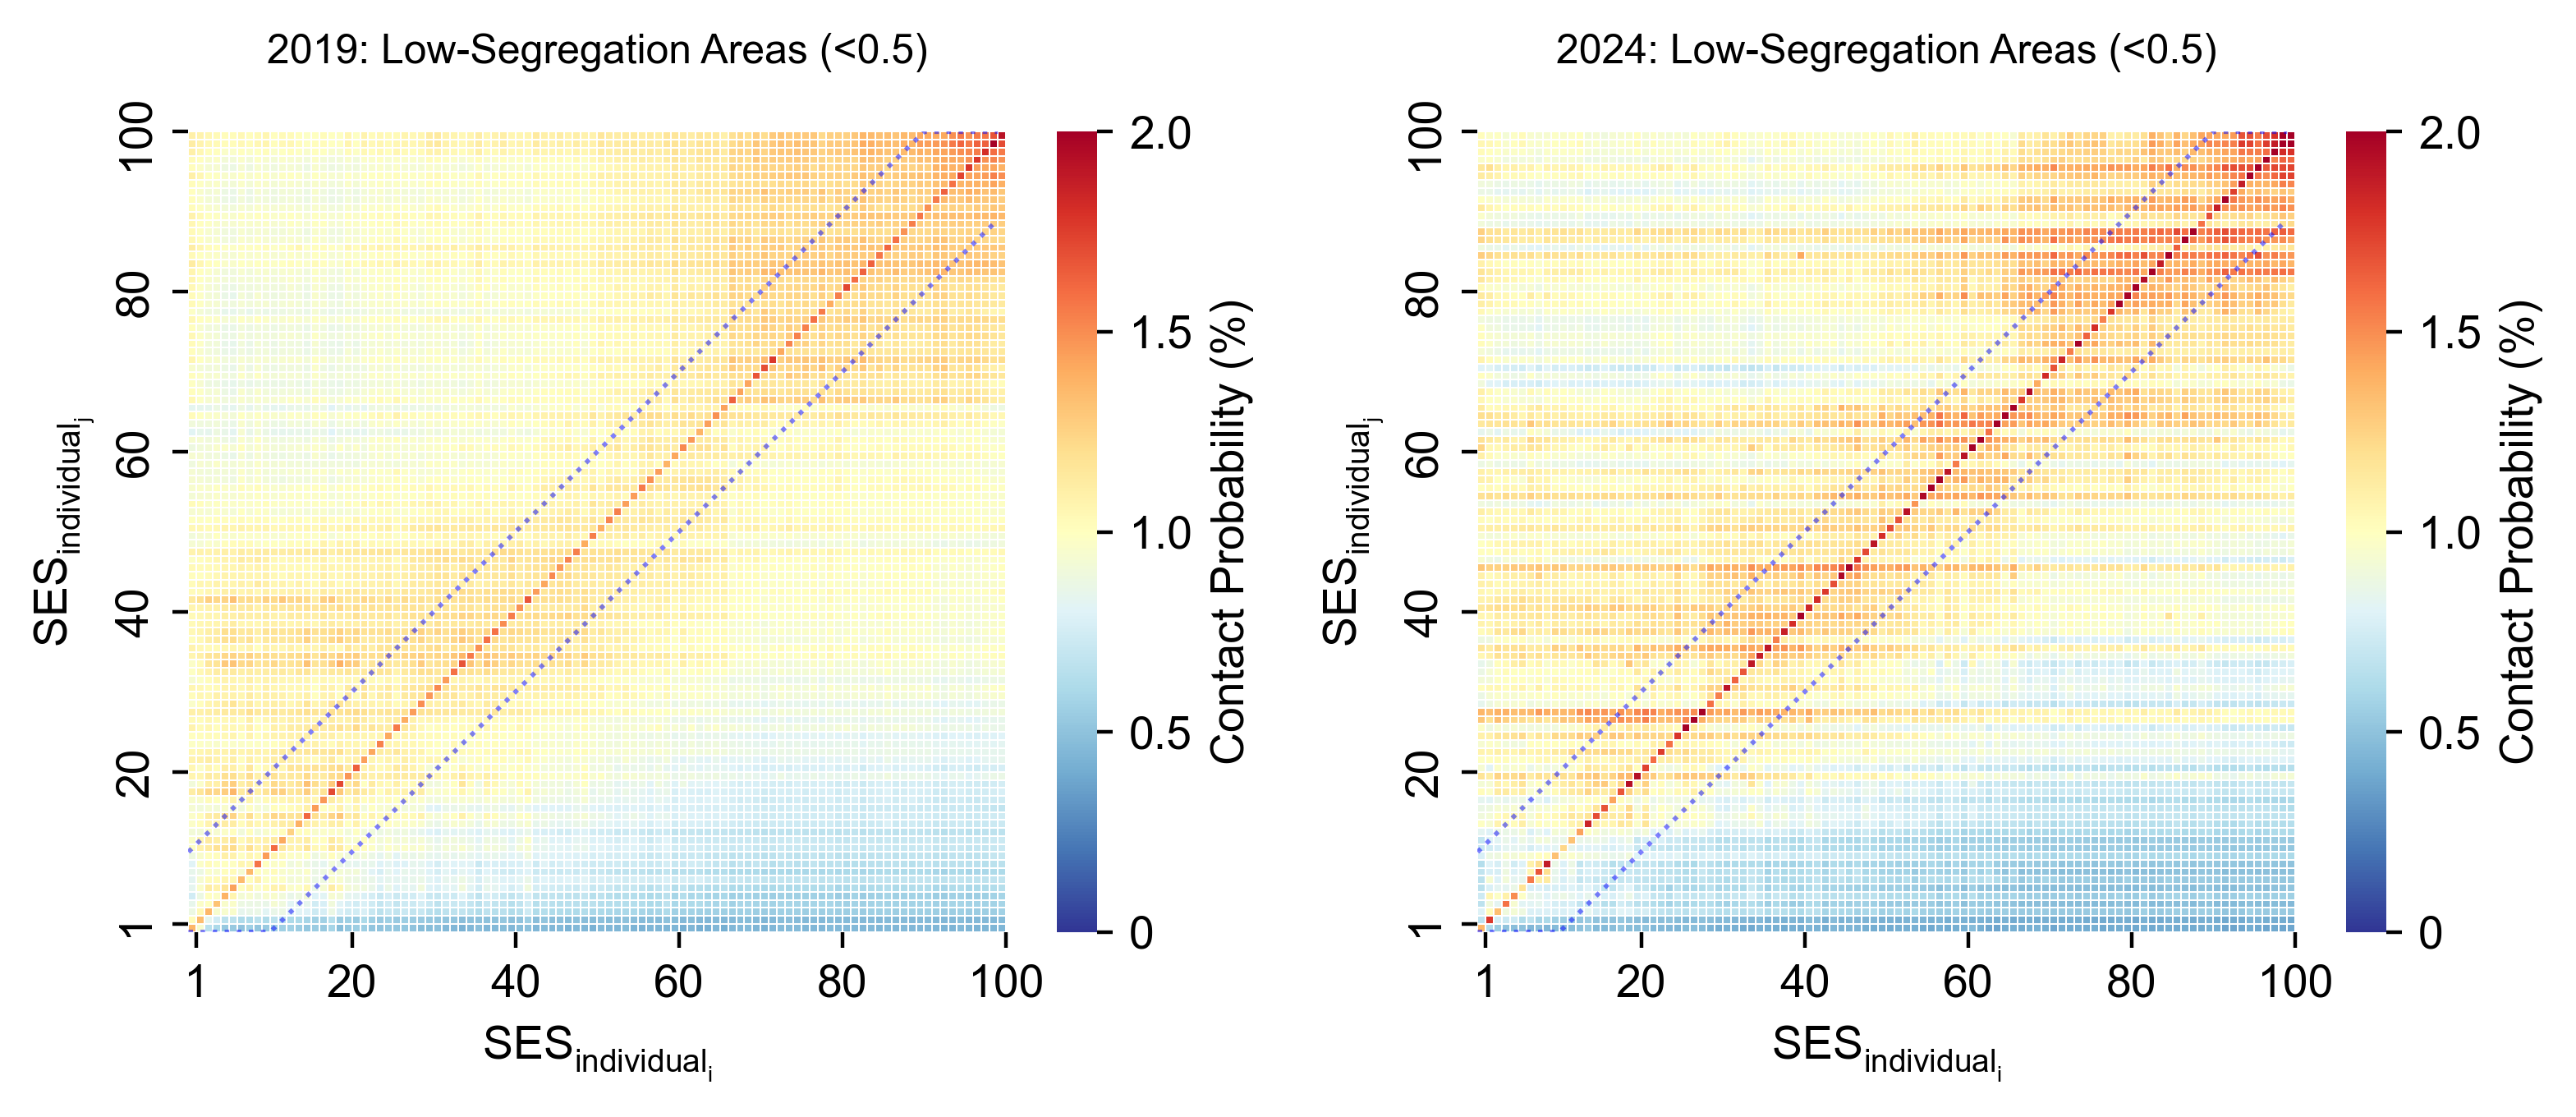

SE Index for Situation 6:
2019: 0.23177935886006257
2024: 0.2421152938213218


C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_41640\824944262.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()


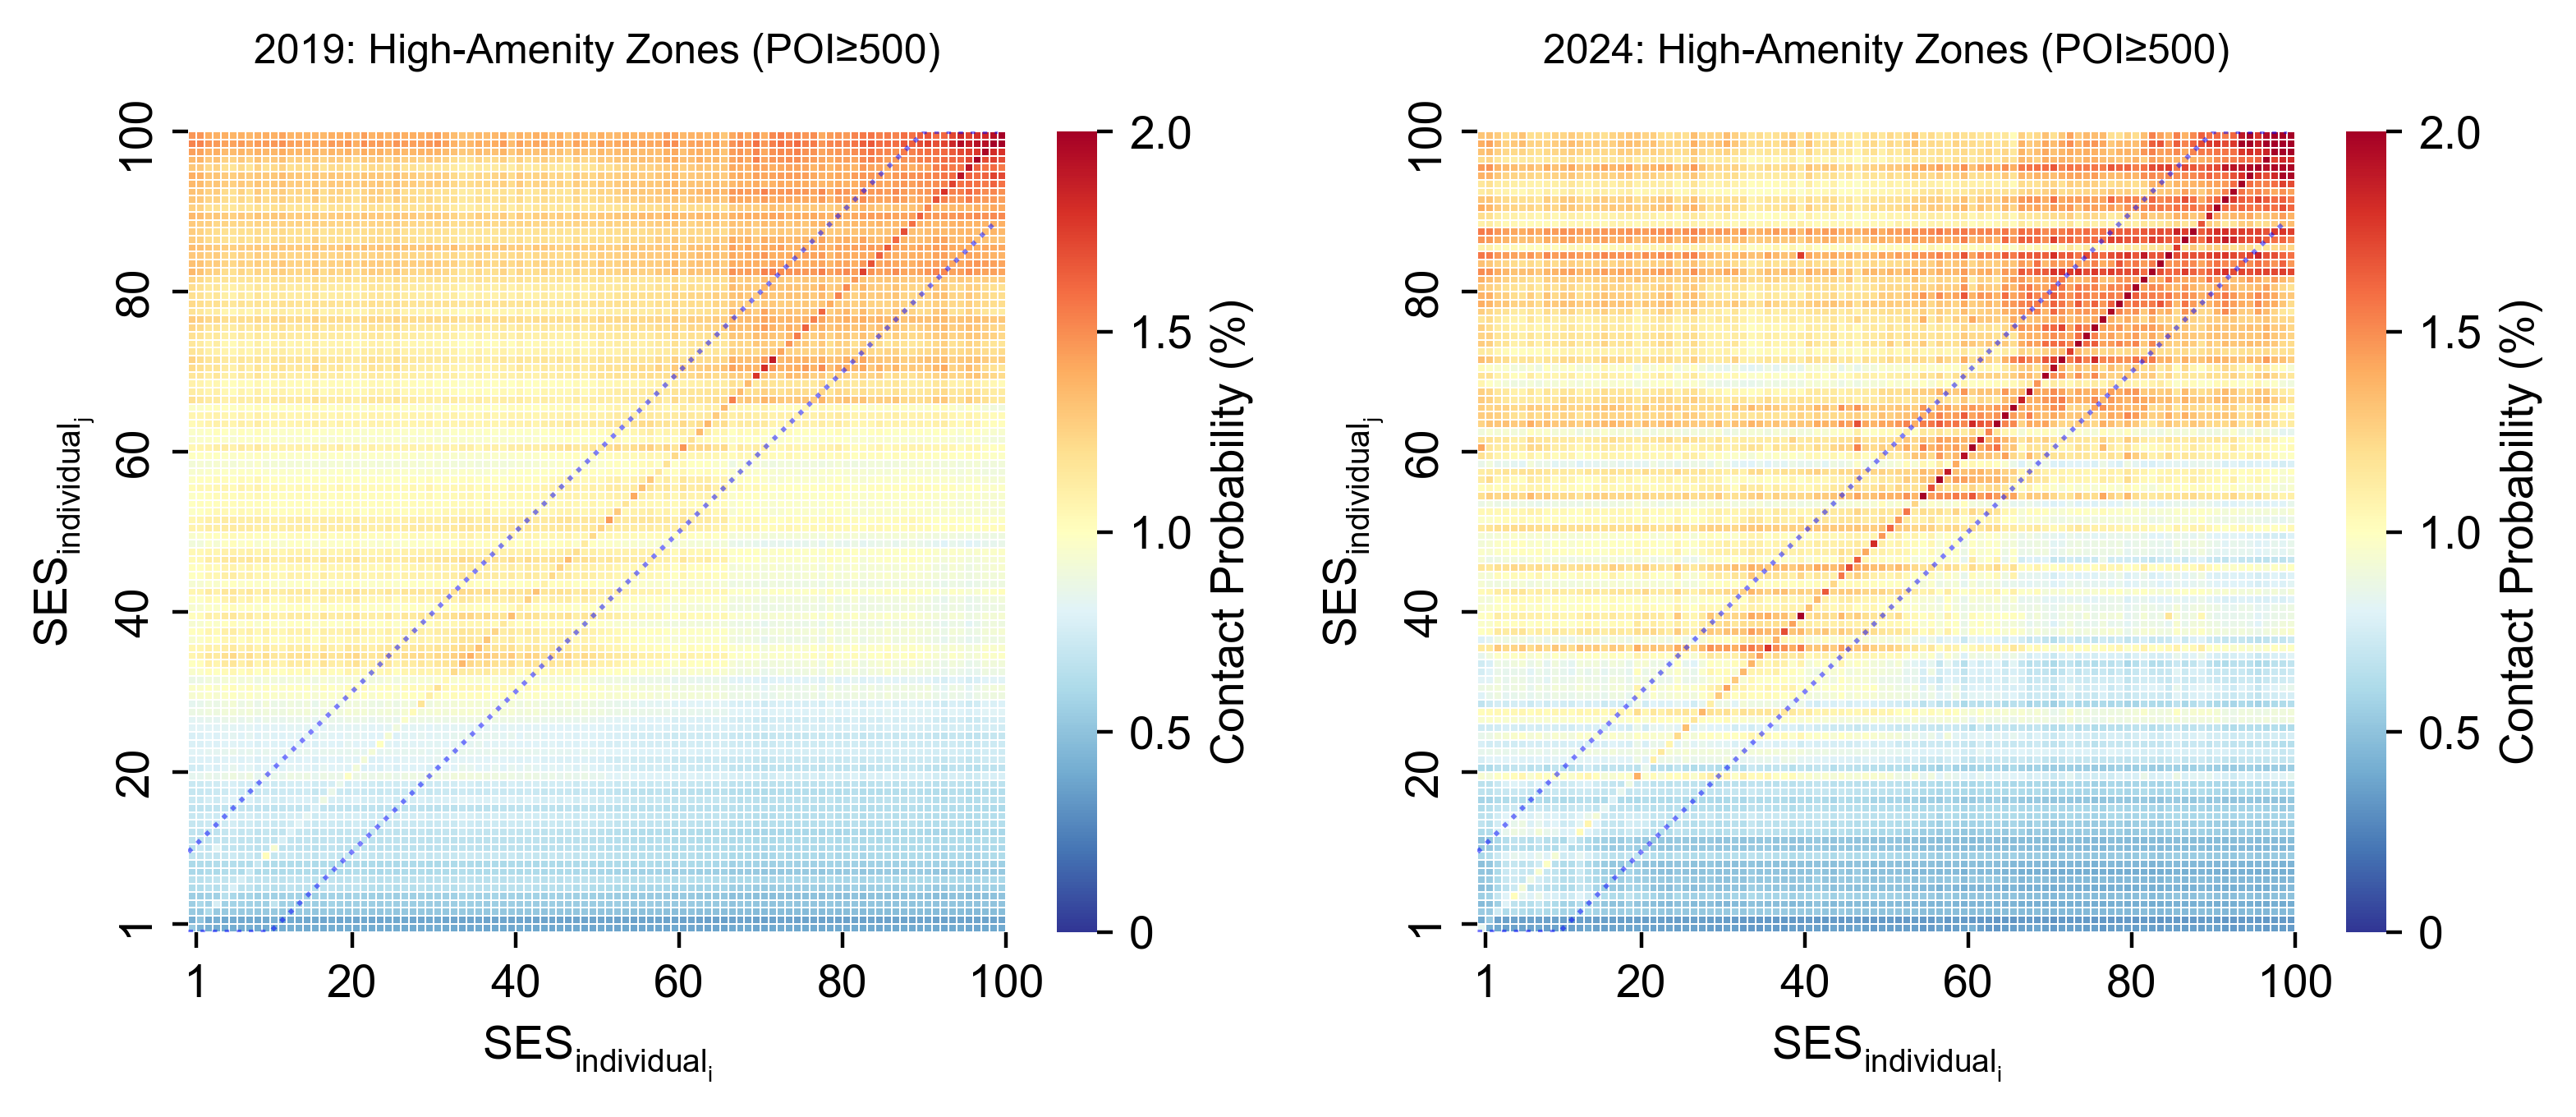

SE Index for Situation 7:
2019: 0.21707272439837283
2024: 0.23373598237061607


In [20]:
# Common setup and functions
group_list = ['home_grid', 'age', 'gender', 'is_local']

# Data preparation functions
def data_prepross(df):
    """Clean and prepare mobility data"""
    df = df.loc[df['visit_grid'].isin(sixth_fnid)]
    visit_count = df.loc[:,['visit_grid','home_grid']].groupby('visit_grid', as_index=False).count()
    df = df.loc[df['visit_grid'].isin(np.array(visit_count.loc[visit_count['home_grid']>=3]['visit_grid']))]
    df = df.loc[df['gender'].isin([1,2])]
    visit_fre = df.loc[:,['home_grid','stay_fre']].groupby('home_grid', as_index=False).sum()
    df = df.loc[df['home_grid'].isin(visit_fre.loc[visit_fre['stay_fre']>60]['home_grid'])]
    df = df.loc[df['age'].isin(['a2','a3','a4','a5','a6','a7'])]
    df_ses = df.merge(house_price_pop.loc[:,['home_grid','ses','ses2', 'ses3']])
    return df_ses

def calculate_visit_flow_sankey(od_data):
    """Calculate contact probability matrix"""
    ses = 'ses'
    data_new = data_prepross(od_data)
    a = data_new.loc[:, [ses, 'visit_grid', 'sum_time']]
    visit_ses = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby(['visit_grid', ses]).sum().unstack().fillna(0).stack().reset_index()
    group1 = a.loc[:, ['visit_grid', ses, 'sum_time']].groupby([ses, 'visit_grid'], as_index=False).sum()
    group2 = a.loc[:, [ses, 'sum_time']].groupby([ses], as_index=False).sum().rename(columns={'sum_time': 'sum_time_sum'})
    result = group1.merge(group2, on=ses)
    result['visit_prob'] = result['sum_time'] / result['sum_time_sum']
    result = result.loc[:, [ses, 'visit_grid', 'visit_prob']]
    result_new = result.merge(visit_ses, on=['visit_grid'], suffixes=('', '_meet')).drop('visit_grid', axis=1)
    result_new['meet_prob'] = result_new['visit_prob'] * result_new['sum_time']
    result_new = result_new.loc[:, [ses, ses+'_meet', 'meet_prob']].groupby([ses, ses+'_meet'], as_index=False).sum()
    result_new['meet_prob_norm'] = result_new.groupby(ses)['meet_prob'].transform(lambda x: x / x.sum())
    return result_new.loc[:,['ses','ses_meet','meet_prob_norm']].pivot(index="ses_meet", columns="ses", values="meet_prob_norm")

def plot_visit_prefer(visit_matrix, ax=None, add_colorbar=False):
    """Visualize contact probability matrix"""
    cuts = 100
    if ax is None:
        f, ax = plt.subplots(figsize=(5, 4.5))
    
    sns.heatmap(visit_matrix, annot=False, linewidths=.3, cmap="RdYlBu_r", vmin=0.00, vmax=2, ax=ax)
    
    ax.set_xticks([1, 20, 40, 60, 80, 100])
    ax.set_xticklabels([1, 20, 40, 60, 80, 100])
    ax.set_yticks([1, 20, 40, 60, 80, 100])
    ax.set_yticklabels([1, 20, 40, 60, 80, 100])
    ax.invert_yaxis()
    
    ax.set_xlabel(r'$\mathregular{SES_{individual_{i}}}$')
    ax.set_ylabel(r'$\mathregular{SES_{individual_{j}}}$')
    
    x = np.arange(0, cuts)
    ax.plot(x, np.clip(x + 10, 0, cuts), 'b:', linewidth=1, alpha=0.5)
    ax.plot(x, np.clip(x - 10, 0, cuts), 'b:', linewidth=1, alpha=0.5)
    
    if add_colorbar:
        cbar = ax.collections[0].colorbar
        cbar.set_label('Contact Probability (%)')
        cbar.set_ticks([0, 0.5, 1, 1.5, 2])
        cbar.set_ticklabels(['0', '0.5', '1.0', '1.5', '2.0'])
    return ax

def cal_SE_index(trip_matrix, max_distance=10):
    """Calculate segregation index"""
    L = trip_matrix.shape[0]
    phi = 0.0
    phi += np.sum(np.diag(trip_matrix))
    for k in range(1, max_distance + 1):
        for i in range(L - k):
            phi += trip_matrix[i, i + k]
            phi += trip_matrix[i + k, i]
    return phi / L

# Configure Matplotlib global style
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',
    'figure.dpi': 400,
    'font.size': 10
})

# =============================================
# Situation 1: Top 10 visit points
# =============================================
top_10_visit_points_1903 = (visit_prob_stat1903
                       .loc[:, ['home_grid', 'age', 'gender', 'is_local', 'ses', 'visit_grid', 'sum_time', 'visit_prob']]
                       .sort_values('visit_prob', ascending=False)
                       .groupby(['home_grid', 'age', 'gender', 'is_local', 'ses'])
                       .head(10)
                       .reset_index(drop=True))
top_10_visit_points_1903 = top_10_visit_points_1903.merge(od1903.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)

top_10_visit_points_2403 = (visit_prob_stat2403
                       .loc[:, ['home_grid', 'age', 'gender', 'is_local', 'ses', 'visit_grid', 'sum_time', 'visit_prob']]
                       .sort_values('visit_prob', ascending=False)
                       .groupby(['home_grid', 'age', 'gender', 'is_local', 'ses'])
                       .head(10)
                       .reset_index(drop=True))
top_10_visit_points_2403 = top_10_visit_points_2403.merge(od2403.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)

a1903 = calculate_visit_flow_sankey(top_10_visit_points_1903)
a2403 = calculate_visit_flow_sankey(top_10_visit_points_2403)

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=False)
axs = axs.flatten()
plot_visit_prefer(a1903 * 100, axs[0], add_colorbar=True)
plot_visit_prefer(a2403 * 100, axs[1], add_colorbar=True)
axs[0].set_title('2019: Top 10% Destinations', fontsize=9, pad=15)
axs[1].set_title('2024: Top 10% Destinations', fontsize=9, pad=15)
plt.tight_layout()
plt.show()

print("SE Index for Situation 1:")
print("2019:", cal_SE_index(np.nan_to_num(a1903.to_numpy())))
print("2024:", cal_SE_index(np.nan_to_num(a2403.to_numpy())))

# =============================================
# Situation 2: After top 10 visit points
# =============================================
after_top_10_points_1903 = (visit_prob_stat1903
                       .loc[:, ['home_grid', 'age', 'gender', 'is_local', 'ses', 'visit_grid', 'sum_time', 'visit_prob']]
                       .sort_values('visit_prob', ascending=True)
                       .groupby(['home_grid', 'age', 'gender', 'is_local', 'ses'])
                       .tail(-10)
                       .reset_index(drop=True))
after_top_10_points_2403 = (visit_prob_stat2403
                       .loc[:, ['home_grid', 'age', 'gender', 'is_local', 'ses', 'visit_grid', 'sum_time', 'visit_prob']]
                       .sort_values('visit_prob', ascending=True)
                       .groupby(['home_grid', 'age', 'gender', 'is_local', 'ses'])
                       .tail(-10)
                       .reset_index(drop=True))
after_top_10_points_1903 = after_top_10_points_1903.merge(od1903.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)
after_top_10_points_2403 = after_top_10_points_2403.merge(od2403.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)

b1903 = calculate_visit_flow_sankey(after_top_10_points_1903)
b2403 = calculate_visit_flow_sankey(after_top_10_points_2403)

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=False)
axs = axs.flatten()
plot_visit_prefer(b1903 * 100, axs[0], add_colorbar=True)
plot_visit_prefer(b2403 * 100, axs[1], add_colorbar=True)
axs[0].set_title('2019: Non-Core Destinations (Bottom 90%)', fontsize=9, pad=15)
axs[1].set_title('2024: Non-Core Destinations (Bottom 90%)', fontsize=9, pad=15)
plt.tight_layout()
plt.show()

print("SE Index for Situation 2:")
print("2019:", cal_SE_index(np.nan_to_num(b1903.to_numpy())))
print("2024:", cal_SE_index(np.nan_to_num(b2403.to_numpy())))

# =============================================
# Situation 3: Distance <= 5000
# =============================================
short_dist_1903 = visit_prob_stat1903.loc[visit_prob_stat1903['distance']<=5000]
short_dist_2403 = visit_prob_stat2403.loc[visit_prob_stat2403['distance']<=5000]

short_dist_1903 = short_dist_1903.merge(od1903.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)
short_dist_2403 = short_dist_2403.merge(od2403.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)

c1903 = calculate_visit_flow_sankey(short_dist_1903)
c2403 = calculate_visit_flow_sankey(short_dist_2403)

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=False)
axs = axs.flatten()
plot_visit_prefer(c1903 * 100, axs[0], add_colorbar=True)
plot_visit_prefer(c2403 * 100, axs[1], add_colorbar=True)
axs[0].set_title('2019: Short-Distance Mobility (<5km)', fontsize=9, pad=15)
axs[1].set_title('2024: Short-Distance Mobility (<5km)', fontsize=9, pad=15)
plt.tight_layout()
plt.show()

print("SE Index for Situation 3:")
print("2019:", cal_SE_index(np.nan_to_num(c1903.to_numpy())))
print("2024:", cal_SE_index(np.nan_to_num(c2403.to_numpy())))

# =============================================
# Situation 4: Distance > 20000
# =============================================
long_dist_1903 = visit_prob_stat1903.loc[visit_prob_stat1903['distance']>20000]
long_dist_2403 = visit_prob_stat2403.loc[visit_prob_stat2403['distance']>20000]

long_dist_1903 = long_dist_1903.merge(od1903.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)
long_dist_2403 = long_dist_2403.merge(od2403.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)

d1903 = calculate_visit_flow_sankey(long_dist_1903)
d2403 = calculate_visit_flow_sankey(long_dist_2403)

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=False)
axs = axs.flatten()
plot_visit_prefer(d1903 * 100, axs[0], add_colorbar=True)
plot_visit_prefer(d2403 * 100, axs[1], add_colorbar=True)
axs[0].set_title('2019: Long-Distance Commuting (>20km)', fontsize=9, pad=15)
axs[1].set_title('2024: Long-Distance Commuting (>20km)', fontsize=9, pad=15)
plt.tight_layout()
plt.show()

print("SE Index for Situation 4:")
print("2019:", cal_SE_index(np.nan_to_num(d1903.to_numpy())))
print("2024:", cal_SE_index(np.nan_to_num(d2403.to_numpy())))

# =============================================
# Situation 5: 5000 < Distance < 20000
# =============================================
med_dist_1903 = visit_prob_stat1903.loc[(visit_prob_stat1903['distance']>5000) & (visit_prob_stat1903['distance']<20000)]
med_dist_2403 = visit_prob_stat2403.loc[(visit_prob_stat2403['distance']>5000) & (visit_prob_stat2403['distance']<20000)]

med_dist_1903 = med_dist_1903.merge(od1903.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)
med_dist_2403 = med_dist_2403.merge(od2403.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)

e1903 = calculate_visit_flow_sankey(med_dist_1903)
e2403 = calculate_visit_flow_sankey(med_dist_2403)

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=False)
axs = axs.flatten()
plot_visit_prefer(e1903 * 100, axs[0], add_colorbar=True)
plot_visit_prefer(e2403 * 100, axs[1], add_colorbar=True)
axs[0].set_title('2019: Medium-Range Mobility (5-20km)', fontsize=9, pad=15)
axs[1].set_title('2024: Medium-Range Mobility (5-20km)', fontsize=9, pad=15)
plt.tight_layout()
plt.show()

print("SE Index for Situation 5:")
print("2019:", cal_SE_index(np.nan_to_num(e1903.to_numpy())))
print("2024:", cal_SE_index(np.nan_to_num(e2403.to_numpy())))

# =============================================
# Situation 6: Isolation < 0.5
# =============================================
low_seg_1903 = visit_prob_stat1903.loc[visit_prob_stat1903['isolation']<0.5]
low_seg_2403 = visit_prob_stat2403.loc[visit_prob_stat2403['isolation']<0.5]

low_seg_1903 = low_seg_1903.merge(od1903.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)
low_seg_2403 = low_seg_2403.merge(od2403.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)

f1903 = calculate_visit_flow_sankey(low_seg_1903)
f2403 = calculate_visit_flow_sankey(low_seg_2403)

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=False)
axs = axs.flatten()
plot_visit_prefer(f1903 * 100, axs[0], add_colorbar=True)
plot_visit_prefer(f2403 * 100, axs[1], add_colorbar=True)
axs[0].set_title('2019: Low-Segregation Areas (<0.5)', fontsize=9, pad=15)
axs[1].set_title('2024: Low-Segregation Areas (<0.5)', fontsize=9, pad=15)
plt.tight_layout()
plt.show()

print("SE Index for Situation 6:")
print("2019:", cal_SE_index(np.nan_to_num(f1903.to_numpy())))
print("2024:", cal_SE_index(np.nan_to_num(f2403.to_numpy())))

# =============================================
# Situation 7: POI number >= 500
# =============================================
high_poi_1903 = visit_prob_stat1903.loc[visit_prob_stat1903['poi_num']>=500]
high_poi_2403 = visit_prob_stat2403.loc[visit_prob_stat2403['poi_num']>=500]

high_poi_1903 = high_poi_1903.merge(od1903.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)
high_poi_2403 = high_poi_2403.merge(od2403.loc[:, group_list+['stay_fre']].groupby(group_list, as_index=False).sum(), on=group_list)

g1903 = calculate_visit_flow_sankey(high_poi_1903)
g2403 = calculate_visit_flow_sankey(high_poi_2403)

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=False)
axs = axs.flatten()
plot_visit_prefer(g1903 * 100, axs[0], add_colorbar=True)
plot_visit_prefer(g2403 * 100, axs[1], add_colorbar=True)
axs[0].set_title('2019: High-Amenity Zones (POI≥500)', fontsize=9, pad=15)
axs[1].set_title('2024: High-Amenity Zones (POI≥500)', fontsize=9, pad=15)
plt.tight_layout()
plt.show()

print("SE Index for Situation 7:")
print("2019:", cal_SE_index(np.nan_to_num(g1903.to_numpy())))
print("2024:", cal_SE_index(np.nan_to_num(g2403.to_numpy())))

# Visiting Probability Statistical Model

In [21]:
visit_prob_stat1903.columns

Index(['home_grid', 'age', 'gender', 'is_local', 'ses', 'visit_grid',
       'sum_time', 'distance', 'visit_prob', 'isolation', 'avg_ses', 'poi_num',
       'poi_entropy', 'poi_num_home', 'pcount', 'avg_fre', 'avg_time',
       'avg_dis', 'entropy', 'age_c', 'gender_c', 'ses_c'],
      dtype='object')

Sample size: 12111662


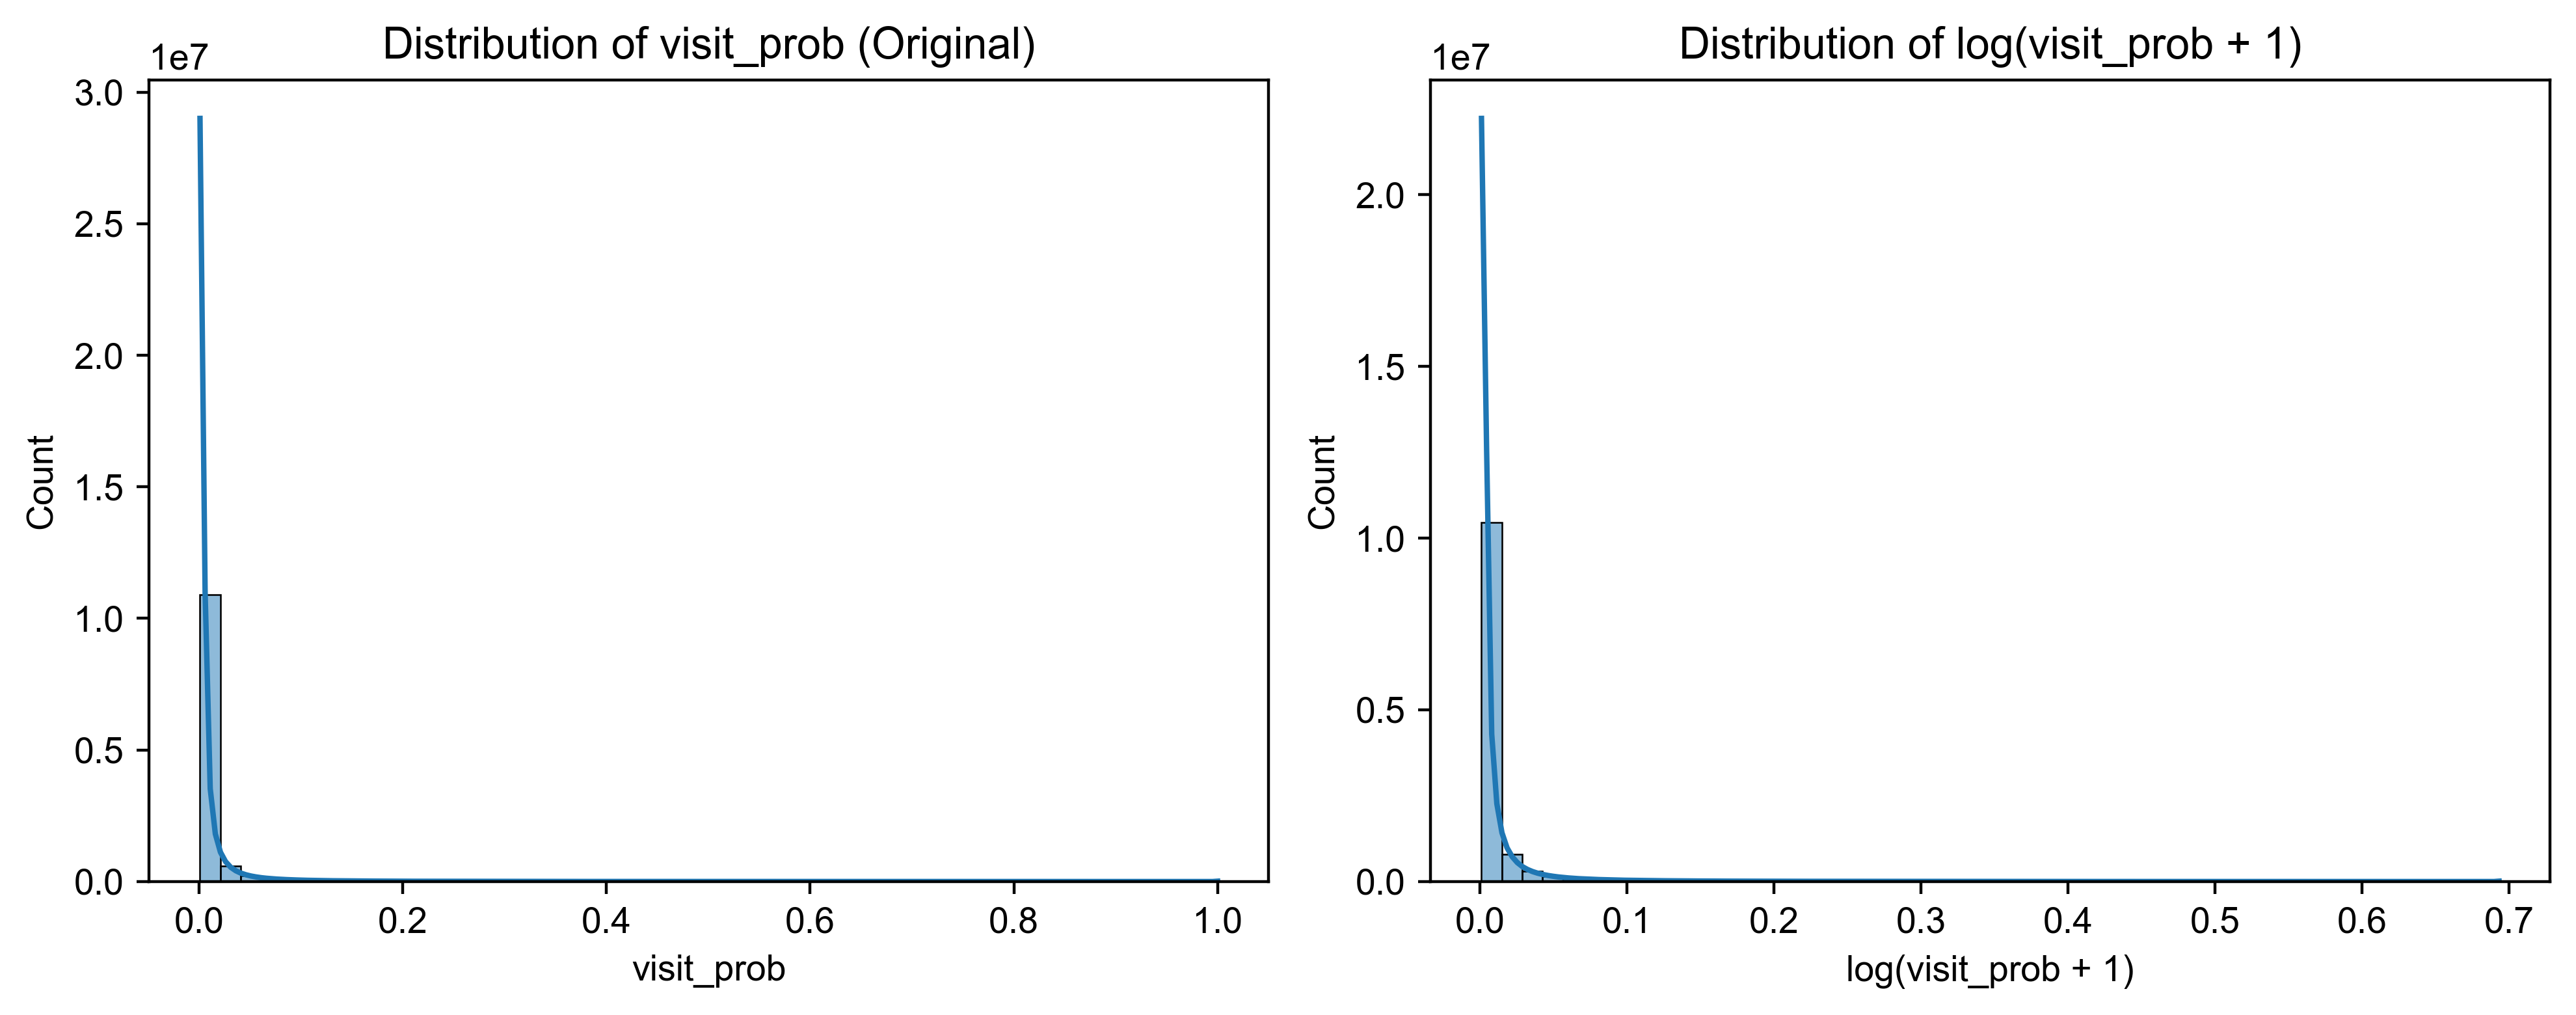

In [22]:
a = visit_prob_stat1903.loc[visit_prob_stat1903['visit_prob'] > 1e-3, 'visit_prob'].values  # 使用.values避免to_list()
log_transformed = np.log(a + 1)
print('Sample size:', len(a))
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(a, kde=True, bins=50)
plt.title('Distribution of visit_prob (Original)')
plt.xlabel('visit_prob')

plt.subplot(1, 2, 2)
sns.histplot(log_transformed, kde=True, bins=50)
plt.title('Distribution of log(visit_prob + 1)')
plt.xlabel('log(visit_prob + 1)')

plt.tight_layout()
plt.show()

## 2019

In [23]:
stat_data = visit_prob_stat1903.loc[
    (visit_prob_stat1903['visit_prob'] > 1e-3) & 
    (visit_prob_stat1903['visit_prob'] <= visit_prob_stat1903['visit_prob'].quantile(0.99))
].copy()

# 1. Baseline Model
print("=== 1. Baseline Demographic Model ===")
base_model = smf.glm(
    "np.log(visit_prob+1) ~ C(age_c) + C(gender_c) + C(ses_c) + C(is_local)",
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(base_model.summary())

# 2. Mobility Model
print("=== 2. + Mobility Patterns ===")
mobility_model = smf.glm(
    """np.log(visit_prob+1) ~ C(age_c) + C(gender_c) + C(ses_c) + C(is_local)
    + avg_fre + avg_time + avg_dis + entropy""",
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(mobility_model.summary())

# 3. Destination Model
print("=== 3. Destination Attributes Only ===")
dest_model = smf.glm(
    """np.log(visit_prob+1) ~ avg_ses + I(avg_ses**2)
    + np.log(poi_num+1) + poi_entropy + np.log(distance+1)""",
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(dest_model.summary())

# 4. Full Model
print("=== 4. Full Combined Model ===")
full_model = smf.glm(
    """np.log(visit_prob+1) ~ C(age_c) + C(gender_c) + C(ses_c) + C(is_local)
    + avg_fre + avg_time + avg_dis + entropy
    + avg_ses + I(avg_ses**2)
    + np.log(poi_num+1) + poi_entropy + np.log(distance+1)""",
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(full_model.summary())

# 5. Interaction Model
print("=== 5. Interaction Model ===")
interaction_model = smf.glm(
    """np.log(visit_prob+1) ~ C(age_c) + C(gender_c) + C(ses_c) + C(is_local)
    + avg_fre + avg_time + avg_dis + entropy
    + avg_ses + I(avg_ses**2) + poi_entropy
    + np.log(poi_num+1) + np.log(distance+1)
    + C(ses_c)*avg_ses + C(is_local)*np.log(distance+1)""", 
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(interaction_model.summary())

=== 1. Baseline Demographic Model ===
                   Generalized Linear Model Regression Results                    
Dep. Variable:     np.log(visit_prob + 1)   No. Observations:             11867699
Model:                                GLM   Df Residuals:                 11867691
Model Family:                    Gaussian   Df Model:                            7
Link Function:                   Identity   Scale:                      0.00011569
Method:                              IRLS   Log-Likelihood:             3.6948e+07
Date:                    Sat, 06 Sep 2025   Deviance:                       1373.0
Time:                            15:55:24   Pearson chi2:                 1.37e+03
No. Iterations:                         3   Pseudo R-squ. (CS):             0.1431
Covariance Type:                nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

In [24]:
def format_coefficients(model, model_name):
    """
    Note: All models use np.log(visit_prob + 1) as the target variable (natural log transformation)
    and are fitted using GLM (Generalized Linear Model) with Gaussian family.
    """
    table = model.summary().tables[1]
    data = []
    variable_categories = {
        'Demographic': ['C(age_c)', 'C(gender_c)', 'C(ses_c)', 'C(is_local)'],
        'Mobility': ['avg_fre', 'avg_time', 'avg_dis', 'entropy'],
        'Destination': ['avg_ses', 'I(avg_ses ** 2)', 'np.log(poi_num + 1)', 'poi_entropy', 'np.log(distance + 1)'],
        'Interaction': ['C(ses_c)*avg_ses', 'C(is_local)*np.log(distance + 1)']
    }
    for row in table.data[1:]:
        if 'Intercept' not in row[0]:
            var = row[0].strip()
            coef = float(row[1])
            std_err = float(row[2])
            pval = float(row[4])
            stars = ('***' if pval < 0.001 else 
                    '**' if pval < 0.01 else 
                    '*' if pval < 0.05 else '')
            effect_size = (np.exp(coef) - 1) * 100
            var_category = next((cat for cat, vars in variable_categories.items() 
                               if any(v in var for v in vars)), 'Other')
            data.append({
                'Variable': var,
                'Category': var_category,
                'Model': model_name,
                'Coefficient': coef,
                'Formatted_Coefficient': f"{coef:.5f}{stars}",
                'Std_Error': std_err,
                'P_Value': pval,
                'Effect_Size (%)': f"{effect_size:.3f}%",
                'CI_Lower': coef - 1.96*std_err,
                'CI_Upper': coef + 1.96*std_err
            })
    df = pd.DataFrame(data)
    category_order = ['Demographic', 'Mobility', 'Destination', 'Interaction', 'Other']
    df['Category'] = pd.Categorical(df['Category'], categories=category_order, ordered=True)
    return df.sort_values(['Category', 'Variable'])

all_results = []
model_names = ['1. Baseline', '2. +Mobility', '3. Destination', '4. Full', '5. +Interaction']
models = [base_model, mobility_model, dest_model, full_model, interaction_model]

for name, model in zip(model_names, models):
    all_results.append(format_coefficients(model, name))
    
coef_df = pd.concat(all_results)

model_stats = pd.DataFrame({
    'Model': model_names,
    'AIC': [f"{m.aic:,.0f}" for m in models],
    'ΔAIC': [m.aic - base_model.aic for m in models],
    'Pseudo_R2': [f"{1 - m.deviance/m.null_deviance:.4f}" for m in models],
    'Sig_Vars': [sum(m.pvalues < 0.05) - 1 for m in models],  # Excluding intercept
    'N': [f"{m.nobs:,}" for m in models],
    'Model_Type': ['GLM (Gaussian)' for _ in models],
    'Target_Variable': ['np.log(visit_prob + 1)' for _ in models]
})

with pd.ExcelWriter('visit_model_results_2019.xlsx', engine='xlsxwriter') as writer:
    pd.DataFrame({
        'Model_Specification': [
            'All models use GLM with Gaussian family',
            'Target variable: np.log(visit_prob + 1) (natural logarithm)',
            'Effect sizes calculated as (exp(β) - 1)*100%',
            'Significance codes: *** p<0.001, ** p<0.01, * p<0.05',
            'Variables grouped by: Demographic, Mobility, Destination, Interaction'
        ]
    }).to_excel(writer, sheet_name='Metadata', index=False)
    
    coef_wide = coef_df.pivot(index=['Category', 'Variable'], columns='Model', 
                             values=['Formatted_Coefficient', 'Effect_Size (%)'])
    coef_wide.to_excel(writer, sheet_name='Main_Coefficients')
    
    (coef_df[['Category', 'Variable', 'Model', 'Formatted_Coefficient', 'Effect_Size (%)', 
             'P_Value', 'CI_Lower', 'CI_Upper']]
     .to_excel(writer, sheet_name='Detailed_Coefficients', index=False))
    
    model_stats.to_excel(writer, sheet_name='Model_Comparison', index=False)
    
    workbook = writer.book
    
    fmt_header = workbook.add_format({
        'bold': True, 
        'text_wrap': True,
        'align': 'center',
        'valign': 'vcenter',
        'border': 1
    })
    
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        worksheet.freeze_panes(1, 0) 
        worksheet.autofilter(0, 0, 0, len(model_stats.columns)-1)
        
        if sheet_name == 'Model_Comparison':
            worksheet.set_column('A:A', 25)
            worksheet.set_column('B:H', 15)
        elif sheet_name == 'Detailed_Coefficients':
            worksheet.set_column('A:B', 20)
            worksheet.set_column('C:H', 15)

print("""
Analysis complete. Key specifications:
- Target variable: np.log(visit_prob + 1) (natural log)
- Model type: GLM with Gaussian family
- Variables grouped by logical categories
- Effect sizes correctly calculated as percentage changes
- Results saved to 'visit_model_results_2019.xlsx'
""")


Analysis complete. Key specifications:
- Target variable: np.log(visit_prob + 1) (natural log)
- Model type: GLM with Gaussian family
- Variables grouped by logical categories
- Effect sizes correctly calculated as percentage changes
- Results saved to 'visit_model_results_2019.xlsx'



## 2024

In [25]:
stat_data = visit_prob_stat2403.loc[
    (visit_prob_stat2403['visit_prob'] > 1e-3) & 
    (visit_prob_stat2403['visit_prob'] <= visit_prob_stat2403['visit_prob'].quantile(0.99))
].copy()

# 1. Baseline Model
print("=== 1. Baseline Demographic Model ===")
base_model = smf.glm(
    "np.log(visit_prob+1) ~ C(age_c) + C(gender_c) + C(ses_c) + C(is_local)",
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(base_model.summary())

# 2. Mobility Model
print("=== 2. + Mobility Patterns ===")
mobility_model = smf.glm(
    """np.log(visit_prob+1) ~ C(age_c) + C(gender_c) + C(ses_c) + C(is_local)
    + avg_fre + avg_time + avg_dis + entropy""",
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(mobility_model.summary())

# 3. Destination Model
print("=== 3. Destination Attributes Only ===")
dest_model = smf.glm(
    """np.log(visit_prob+1) ~ avg_ses + I(avg_ses**2)
    + np.log(poi_num+1) + poi_entropy + np.log(distance+1)""",
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(dest_model.summary())

# 4. Full Model
print("=== 4. Full Combined Model ===")
full_model = smf.glm(
    """np.log(visit_prob+1) ~ C(age_c) + C(gender_c) + C(ses_c) + C(is_local)
    + avg_fre + avg_time + avg_dis + entropy
    + avg_ses + I(avg_ses**2)
    + np.log(poi_num+1) + poi_entropy + np.log(distance+1)""",
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(full_model.summary())

# 5. Interaction Model
print("=== 5. Interaction Model ===")
interaction_model = smf.glm(
    """np.log(visit_prob+1) ~ C(age_c) + C(gender_c) + C(ses_c) + C(is_local)
    + avg_fre + avg_time + avg_dis + entropy
    + avg_ses + I(avg_ses**2) + poi_entropy
    + np.log(poi_num+1) + np.log(distance+1)
    + C(ses_c)*avg_ses + C(is_local)*np.log(distance+1)""", 
    data=stat_data,
    family=sm.families.Gaussian()
).fit()
print(interaction_model.summary())

=== 1. Baseline Demographic Model ===
                   Generalized Linear Model Regression Results                    
Dep. Variable:     np.log(visit_prob + 1)   No. Observations:             12059548
Model:                                GLM   Df Residuals:                 12059540
Model Family:                    Gaussian   Df Model:                            7
Link Function:                   Identity   Scale:                      9.1806e-05
Method:                              IRLS   Log-Likelihood:             3.8940e+07
Date:                    Sat, 06 Sep 2025   Deviance:                       1107.1
Time:                            16:08:31   Pearson chi2:                 1.11e+03
No. Iterations:                         3   Pseudo R-squ. (CS):            0.02920
Covariance Type:                nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

In [26]:
all_results = []
model_names = ['1. Baseline', '2. +Mobility', '3. Destination', '4. Full', '5. +Interaction']
models = [base_model, mobility_model, dest_model, full_model, interaction_model]

for name, model in zip(model_names, models):
    all_results.append(format_coefficients(model, name))
    
coef_df = pd.concat(all_results)

model_stats = pd.DataFrame({
    'Model': model_names,
    'AIC': [f"{m.aic:,.0f}" for m in models],
    'ΔAIC': [m.aic - base_model.aic for m in models],
    'Pseudo_R2': [f"{1 - m.deviance/m.null_deviance:.4f}" for m in models],
    'Sig_Vars': [sum(m.pvalues < 0.05) - 1 for m in models], 
    'N': [f"{m.nobs:,}" for m in models],
    'Model_Type': ['GLM (Gaussian)' for _ in models],
    'Target_Variable': ['np.log(visit_prob + 1)' for _ in models]
})

with pd.ExcelWriter('visit_model_results_2024.xlsx', engine='xlsxwriter') as writer:
    # Add model metadata sheet
    pd.DataFrame({
        'Model_Specification': [
            'All models use GLM with Gaussian family',
            'Target variable: np.log(visit_prob + 1) (natural logarithm)',
            'Effect sizes calculated as (exp(β) - 1)*100%',
            'Significance codes: *** p<0.001, ** p<0.01, * p<0.05',
            'Variables grouped by: Demographic, Mobility, Destination, Interaction'
        ]
    }).to_excel(writer, sheet_name='Metadata', index=False)
    
    coef_wide = coef_df.pivot(index=['Category', 'Variable'], columns='Model', 
                             values=['Formatted_Coefficient', 'Effect_Size (%)'])
    coef_wide.to_excel(writer, sheet_name='Main_Coefficients')
    
    (coef_df[['Category', 'Variable', 'Model', 'Formatted_Coefficient', 'Effect_Size (%)', 
             'P_Value', 'CI_Lower', 'CI_Upper']]
     .to_excel(writer, sheet_name='Detailed_Coefficients', index=False))
    
    model_stats.to_excel(writer, sheet_name='Model_Comparison', index=False)
    
    workbook = writer.book
    
    fmt_header = workbook.add_format({
        'bold': True, 
        'text_wrap': True,
        'align': 'center',
        'valign': 'vcenter',
        'border': 1
    })
    
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        worksheet.freeze_panes(1, 0)
        worksheet.autofilter(0, 0, 0, len(model_stats.columns)-1) 
        
        if sheet_name == 'Model_Comparison':
            worksheet.set_column('A:A', 25)
            worksheet.set_column('B:H', 15)
        elif sheet_name == 'Detailed_Coefficients':
            worksheet.set_column('A:B', 20)
            worksheet.set_column('C:H', 15)

print("""
Analysis complete. Key specifications:
- Target variable: np.log(visit_prob + 1) (natural log)
- Model type: GLM with Gaussian family
- Variables grouped by logical categories
- Effect sizes correctly calculated as percentage changes
- Results saved to 'visit_model_results_2024.xlsx'
""")


Analysis complete. Key specifications:
- Target variable: np.log(visit_prob + 1) (natural log)
- Model type: GLM with Gaussian family
- Variables grouped by logical categories
- Effect sizes correctly calculated as percentage changes
- Results saved to 'visit_model_results_2024.xlsx'

